# How to carry out differential expression analysis using RUVSeq and DESeq2

This documentation contains instruction on how to carry out differential expression analysis with latent variables using RUVSeq and DESeq2.

We will carry out the analysis for top 6 most abundance cell types, namely "ActiveStellate", "Delta", "Acinar", "Beta", "Ductal", and "Alpha". For illustration purpose, this notebook will focus on Beta cells as an example. At the end of this document, there are intructions on how to set up a Snakemake file to run RUVSeq and DESeq2 for all cell types.

## Differential expression analysis for Beta cells

In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(stringr))
suppressMessages(library(parallel))
suppressMessages(library(readr))
suppressMessages(library(DESeq2))
suppressMessages(library(limma))
suppressMessages(library(edgeR))
suppressMessages(library(GenomicFeatures))
suppressMessages(library(data.table))
library(ggplot2)
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(S4Vectors))
suppressPackageStartupMessages(library(GenomicRanges))
library(patchwork)
library(biomaRt)

suppressPackageStartupMessages(library("RUVSeq"))
suppressPackageStartupMessages(library("ComplexHeatmap"))
suppressPackageStartupMessages(library("friendlyeval"))

source("/nfs/turbo/umms-scjp-pank/5_DEG/scripts/PanKbase-DEG-analysis/scripts/0_utils.R")

### Set up basic thresholding

To carry out DEG analysis, we use the following criteria:
- Keep non-treated samples with > 20 cells, where the donor has a `diabetes_status_description` of `type 1 diabetes` or `non-diabetes`.
- If one donor has multiple samples, randomly choose one sample
- Keep protein-coding genes with >= 10 raw counts in >= 25% of samples
- Keep cell types with total number of samples >= 20

In [2]:
cell.type <- "Beta"
ncells <- 20
minreads <- 10
minprop <- 0.25
nlatent <- 30

input_dir <- paste0("/nfs/turbo/umms-scjp-pank/5_DEG/results/ruvseq_analysis/20250516_ncells", ncells, "_minreads", minreads, "_minprop", minprop, "_withoutAAB/") # change this dir to path to where data is stored on your system

### Set up coldata, which contains some basic known covariates

In [3]:
samples <- readRDS("/nfs/turbo/umms-scjp-pank/5_DEG/results/samplelist.rds") # sample list
meta_in_sc <- readRDS("/nfs/turbo/umms-scjp-pank/5_DEG/results/metadata_for_DEG.rds")
cell.prop <- read.table(paste0("/nfs/turbo/umms-scjp-pank/5_DEG/results/cell_proportion/cell.prop_", cell.type, ".txt"), header = T) # cell counts and proportions in large map
metadata <- meta_in_sc
metadata <- metadata[metadata$treatments == "no_treatment",]

a <- data.frame(table(metadata$rrid))
coldata <- metadata[metadata$rrid %in% a[a$Freq == 1, "Var1"],]
for (i in a[a$Freq > 1, "Var1"]) {
    tmp <- metadata[metadata$rrid == i,]
    set.seed(1234)
    tmp <- tmp[sample(1:nrow(tmp), 1),]
    coldata <- rbind(coldata, tmp) #coldata has unique sample per donor; no donor has multiple samples
}

In [4]:
# filter samples based on the number of cells
cell.prop <- inner_join(cell.prop, metadata, by = c("Var1" = "samples"))
cell.prop$aab <- "0"
cell.prop$aab <- ifelse(cell.prop$aab_gada == "TRUE", "AAB+", cell.prop$aab)
cell.prop$aab <- ifelse(cell.prop$aab_ia_2 == "TRUE", "AAB+", cell.prop$aab)
cell.prop$aab <- ifelse(cell.prop$aab_iaa == "TRUE", "AAB+", cell.prop$aab)
cell.prop$aab <- ifelse(cell.prop$aab_znt8 == "TRUE", "AAB+", cell.prop$aab)
cell.prop$diabetes_status_description <- ifelse(cell.prop$aab == "0" & cell.prop$diabetes_status_description != "T1DM",
                                                cell.prop$diabetes_status_description,
                                                ifelse(cell.prop$aab == "AAB+" & cell.prop$diabetes_status_description == "NonDiabetic",
                                                       cell.prop$aab, cell.prop$diabetes_status_description))
tmp <- cell.prop[cell.prop$Freq > ncells,] #keep non-treated samples with > 20 cells

tmp$diabetes_status_description <- factor(tmp$diabetes_status_description, levels = c("NonDiabetic", "PreDiabetic", "AAB+", "T1DM", "T2DM"))
tmp <- cell.prop[cell.prop$Freq > ncells & cell.prop$diabetes_status_description %in% c("NonDiabetic", "T1DM") &
          cell.prop$Var1 %in% intersect(coldata$samples, tmp$Var1),] #keep donor has a `diabetes_status_description` of `type 1 diabetes` or `non-diabetes`

coldata <- coldata[coldata$samples %in% tmp$Var1,]
coldata <- data.frame(coldata)
rownames(coldata) <- coldata$samples

In [5]:
head(coldata)

samples                  mean_nCount_RNA
HP-21337-01__Untreated   HP-21337-01__Untreated   20911.917      
HP-22234-01__Untreated   HP-22234-01__Untreated   21756.776      
HP-23135-01__Untreated   HP-23135-01__Untreated   26292.566      
HP18306-01__no_treatment HP18306-01__no_treatment  9444.599      
HPAP-020                 HPAP-020                 20338.852      
HPAP-028                 HPAP-028                  9416.950      
                         mean_nFeature_RNA mean_rna_total_reads
HP-21337-01__Untreated   4688.170           36583.19           
HP-22234-01__Untreated   5107.683           41858.84           
HP-23135-01__Untreated   5039.874           53161.75           
HP18306-01__no_treatment 2754.280           22674.26           
HPAP-020                 3808.211          126422.54           
HPAP-028                 2042.648          122435.58           
                         mean_rna_uniquely_mapped_reads
HP-21337-01__Untreated    32986.05                     
HP-22234-01__Untreated    37530.74                     
HP-23135-01__Untreated    47035.27                     
HP18306-01__no_treatment  19690.89                     
HPAP-020                 100726.26                     
HPAP-028                 105833.22                     
                         mean_rna_secondary_alignments
HP-21337-01__Untreated    4613.555                    
HP-22234-01__Untreated    5746.296                    
HP-23135-01__Untreated    9120.828                    
HP18306-01__no_treatment  3235.136                    
HPAP-020                 14807.263                    
HPAP-028                 18996.315                    
                         mean_rna_supplementary_alignments
HP-21337-01__Untreated   0                                
HP-22234-01__Untreated   0                                
HP-23135-01__Untreated   0                                
HP18306-01__no_treatment 0                                
HPAP-020                 0                                
HPAP-028                 0                                
                         mean_cell_probability mean_post_cellbender_umis
HP-21337-01__Untreated   0.9999627             22805.59                 
HP-22234-01__Untreated   0.9999809             24135.14                 
HP-23135-01__Untreated   0.9999676             28181.32                 
HP18306-01__no_treatment 0.9999460             10085.55                 
HPAP-020                 0.9999720             21566.70                 
HPAP-028                 0.9999042             10097.36                 
                         mean_pct_cellbender_removed ⋯ age bmi  
HP-21337-01__Untreated   7.564530                    ⋯ 26  30.08
HP-22234-01__Untreated   5.648300                    ⋯ 54  27.86
HP-23135-01__Untreated   8.894159                    ⋯ 26  30.08
HP18306-01__no_treatment 5.902877                    ⋯ 21  27.62
HPAP-020                 5.615210                    ⋯ 14  13.20
HPAP-028                 8.827099                    ⋯  4  17.30
                         diabetes_status_description tissue_source aab_gada
HP-21337-01__Untreated   NonDiabetic                 Prodo         NA      
HP-22234-01__Untreated   NonDiabetic                 Prodo         NA      
HP-23135-01__Untreated   NonDiabetic                 Prodo         NA      
HP18306-01__no_treatment NonDiabetic                 IIDP          NA      
HPAP-020                 T1DM                        HPAP          TRUE    
HPAP-028                 T1DM                        HPAP          FALSE   
                         aab_ia_2 aab_znt8 aab_iaa ethnicity
HP-21337-01__Untreated   NA       NA       NA      Hispanic 
HP-22234-01__Untreated   NA       NA       NA      Hispanic 
HP-23135-01__Untreated   NA       NA       NA      Hispanic 
HP18306-01__no_treatment NA       NA       NA      Hispanic 
HPAP-020                 TRUE     TRUE     TRUE    Caucasian
HPAP-028                 FALSE    FALSE    FALSE   Caucasian


### Exporatory analysis with basic DESeq2 models 

Before running models with latent variables, we explore our data using basic DESeq2 models with known covariates.

In [6]:
dir <- '/nfs/turbo/umms-scjp-pank/5_DEG/results/pseudobulk_counts/'
raw_mat <- read.table(paste0(dir, cell.type, "_sample_gex_total_counts.txt"), header = T)
colnames(raw_mat) <- samples
raw_mat <- raw_mat[, intersect(coldata$samples, tmp$Var1)] # keep only samples with > `n_cells` cells
raw_mat <- raw_mat[, which(colSums(raw_mat) > 0)] # remove samples that do not have any cells in the population

# print out the number of samples per diabetes status
print(table(tmp[tmp$Var1 %in% colnames(raw_mat), "diabetes_status_description"]))

# filter genes that have some min_reads raw counts in at least min_prop ratio of samples
basic_filter <- function (row, min_reads = minreads, min_prop = minprop) {
  mean(row >= min_reads) >= min_prop
}
keep <- apply(raw_mat, 1, basic_filter) #1 means apply the function to each row
raw_mat <- raw_mat[keep, ]

coldata <- coldata[colnames(raw_mat),]

print("check if all rownames(coldata) is in colnames(raw_mat):")
print(all(rownames(coldata) %in% colnames(raw_mat)))

print("check if rownames(coldata) == colnames(raw_mat):")
print(all(rownames(coldata) == colnames(raw_mat)))


NonDiabetic        T1DM 
         56           7 
[1] "check if all rownames(coldata) is in colnames(raw_mat):"
[1] TRUE
[1] "check if rownames(coldata) == colnames(raw_mat):"
[1] TRUE


In [7]:
# make sure known covariates that are factors are indeed factors
for (i in c('study', 'samples', 'rrid', 'treatments', 'chemistry', 'sex', 
            'diabetes_status_description', 'tissue_source', 'ethnicity',
            'aab_gada', 'aab_ia_2', 'aab_iaa', 'aab_znt8')) {
    coldata[, i] <- as.factor(coldata[, i])
    
}
colnames(coldata)[which(colnames(coldata) == "samples")] <- "sample_id"

#### Explore raw data

In [8]:
# normalize for library sizes
size.factors <- DESeq2::estimateSizeFactorsForMatrix(raw_mat)
celltype_norm_counts <- t(apply(raw_mat, 1, function(x) x/size.factors))
celltype_norm_counts.log <- log2(celltype_norm_counts + 1) # add a pseudocount

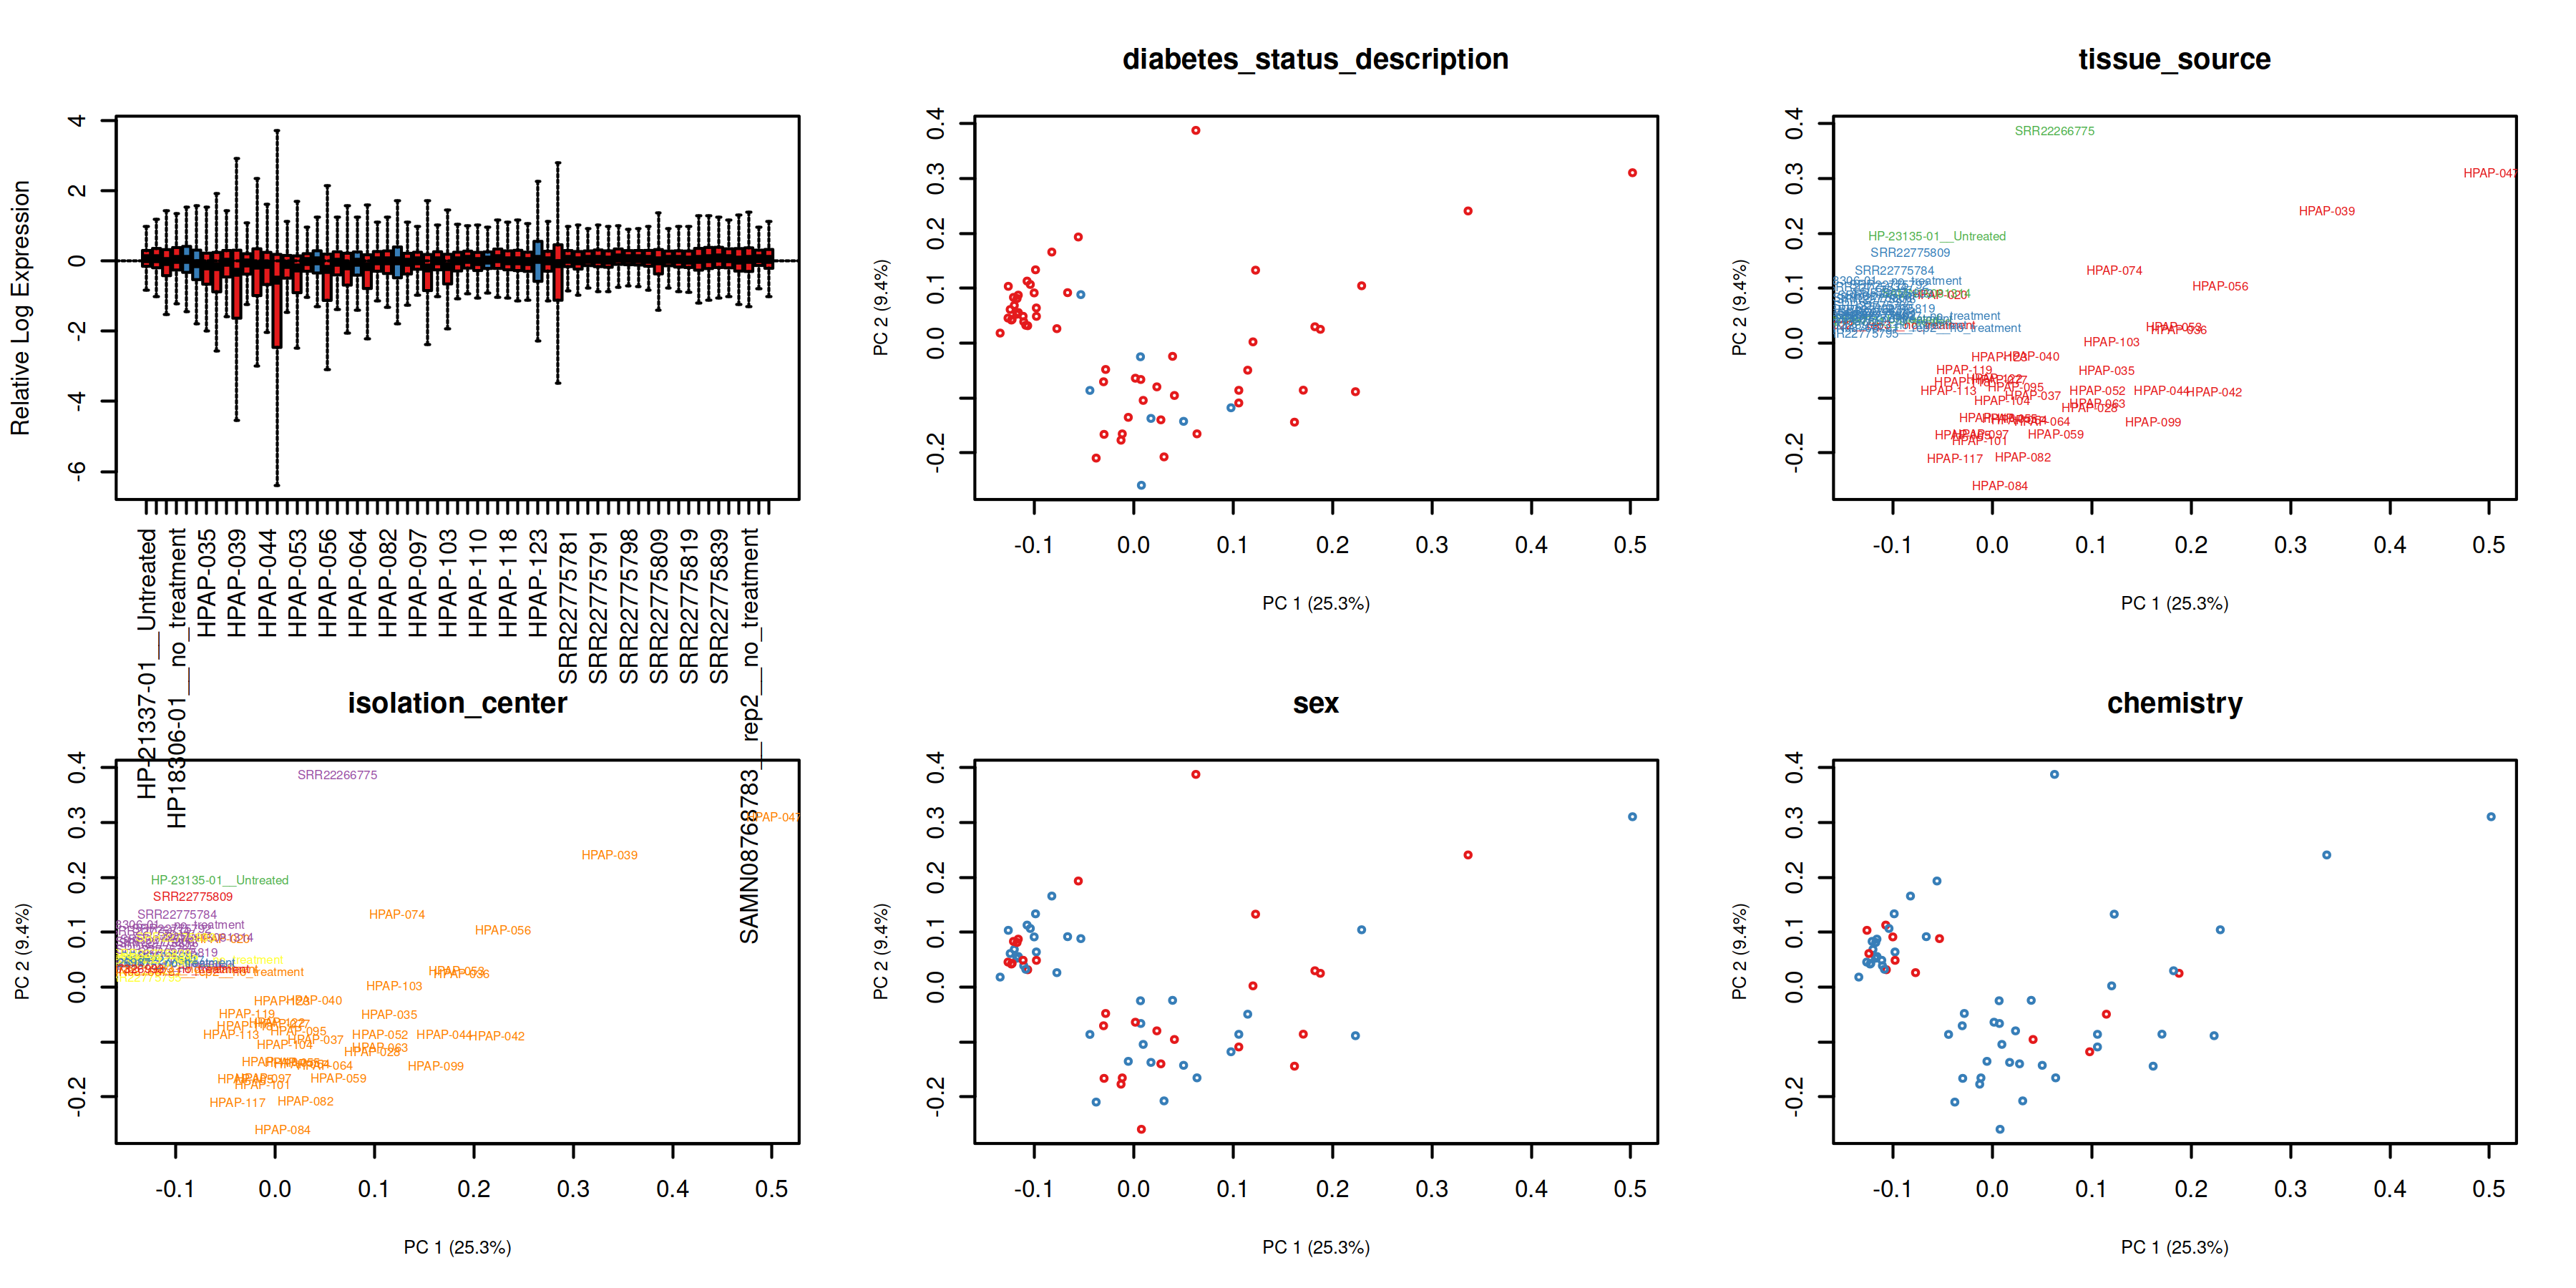

In [9]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 300)

ord_idx <- match(colnames(celltype_norm_counts.log), coldata$sample_id)
group = "diabetes_status_description"
par(mfrow=c(2,3))
colors <- RColorBrewer::brewer.pal(9, "Set1")[as.factor(coldata[ord_idx, ][[group]])]
EDASeq::plotRLE(celltype_norm_counts, col = colors, outline = FALSE, las = 3, cex.axis = 1, ylab = "Relative Log Expression", main = NULL, cex.main = .5)
EDASeq::plotPCA(celltype_norm_counts, col = colors, cex = .5, cex.lab = 0.75, cex.axis = 1, labels = F, main = group)
group = "tissue_source"
colors <- RColorBrewer::brewer.pal(9, "Set1")[as.factor(coldata[ord_idx, ][[group]])]
EDASeq::plotPCA(celltype_norm_counts, col = colors, cex = .5, cex.lab = 0.75, cex.axis = 1, labels = T, main = group)
group = "isolation_center"
colors <- RColorBrewer::brewer.pal(9, "Set1")[as.factor(coldata[ord_idx, ][[group]])]
EDASeq::plotPCA(celltype_norm_counts, col = colors, cex = .5, cex.lab = 0.75, cex.axis = 1, labels = T, main = group)
group = "sex"
colors <- RColorBrewer::brewer.pal(9, "Set1")[as.factor(coldata[ord_idx, ][[group]])]
EDASeq::plotPCA(celltype_norm_counts, col = colors, cex = .5, cex.lab = 0.75, cex.axis = 1, labels = F, main = group)
group = "chemistry"
colors <- RColorBrewer::brewer.pal(9, "Set1")[as.factor(coldata[ord_idx, ][[group]])]
EDASeq::plotPCA(celltype_norm_counts, col = colors, cex = .5, cex.lab = 0.75, cex.axis = 1, labels = F, main = group)

From the plots above, we can see that data is currently not well separated based on `diabetes_status_description` but certain known covariates such as `tissue_source`. However, `diabetes_status_description` is nested within `tissue_source`; therefore, including `tissue_source` in DESeq2 model as a known variable will correct away the biological effects we are interested in. In this case, latent variables estimated using RUVSeq will be crucial to correct for the technical variation while still preserve the biological variation of interest.

Based on covariate analysis, we determined that base model `~ diabetes_status_description+sex+age+bmi+ethnicity+chemistry` is necessary to identify negative control genes (see more technical details at https://www.bioconductor.org/packages//release/bioc/vignettes/RUVSeq/inst/doc/RUVSeq.html#ruvg-estimating-the-factors-of-unwanted-variation-using-control-genes).

In [11]:
dds <- create_dds_obj(raw_mat, coldata)
base_design <- "~ diabetes_status_description+sex+age+bmi+ethnicity"
additional_covs <- c("chemistry")
contrast_vec = c("diabetes_status_description", "T1DM", "NonDiabetic") # fold change = numerator / denominator
celltype_de_explore <- run_many_designs_deseq(
  dds,
  base_design,
  additional_covs,
  contrast = contrast_vec,
  shrink = FALSE
)

info: counts matrix: 13191, 63

info: covariate matrix: 63, 26

info: creating dds object..



info: running design ~ diabetes_status_description+sex+age+bmi+ethnicity
info: running design ~ diabetes_status_description+sex+age+bmi+ethnicity+chemistry


### Latent variable estimation using RUVSeq; using latent variables with DESeq2

Negative control genes are genes with `p-value > 0.5` when usign the base model `~ diabetes_status_description+sex+age+bmi+ethnicity+chemistry`

To decide how many latent variables needed, we first run RUVSeq with a range of `k` for testing purpose. Once we choose a `k`, the models for DESeq2 is ` ~ diabetes_status_description+sex+age+bmi+ethnicity+chemistry + [k RUVSeq variables]`.

In [ ]:
# Run this chunk on a SLURM job in case k is relatively large. When k = 30, it takes ~ 45 mins to run the analysis
dds <- create_dds_obj(celltype_raw_counts, coldata)
celltype_ruvseq <- run_ruvseq(
    dds,
    design = "~ diabetes_status_description+sex+age+bmi+ethnicity+chemistry",
    contrast = contrast_vec,
    k = min(nlatent, 30), #k at most is number of samples - 6 covariates in base model - 1 intercept
    p.val.thresh = 0.5,
    method = "ruvg"
)

We can calculate Spearman correlation between latent variables with known covariates so we can choose a suitable number of latent variables, and explain the meaning of latent variables.

To choose k, we apply the following algorithm:
- Out of all tested k’s, define a k named `k_stop`, which is a k that either significantly correlates with `diabetes status` or is the smallest k that does not significantly correlate with any known variables (Spearman correlation, Benjamini-Hochberg adj. p < 0.05)
- From `k = 1` to `k = k_stop`, scan and select the latest k such that it correlates with at least one unique known variable that is not identified by any other k.

In [13]:
coldata <- data.frame(colData(celltype_de_explore$`~ diabetes_status_description+sex+age+bmi+ethnicity`$dds))

tmp_df <- distinct(cell.prop[, c("Var1", "Freq")])
colnames(tmp_df) <- c("sample_id", "cell_counts")
coldata <- inner_join(coldata, tmp_df, by = c("sample_id" = "sample_id"))
rownames(coldata) <- coldata$sample_id

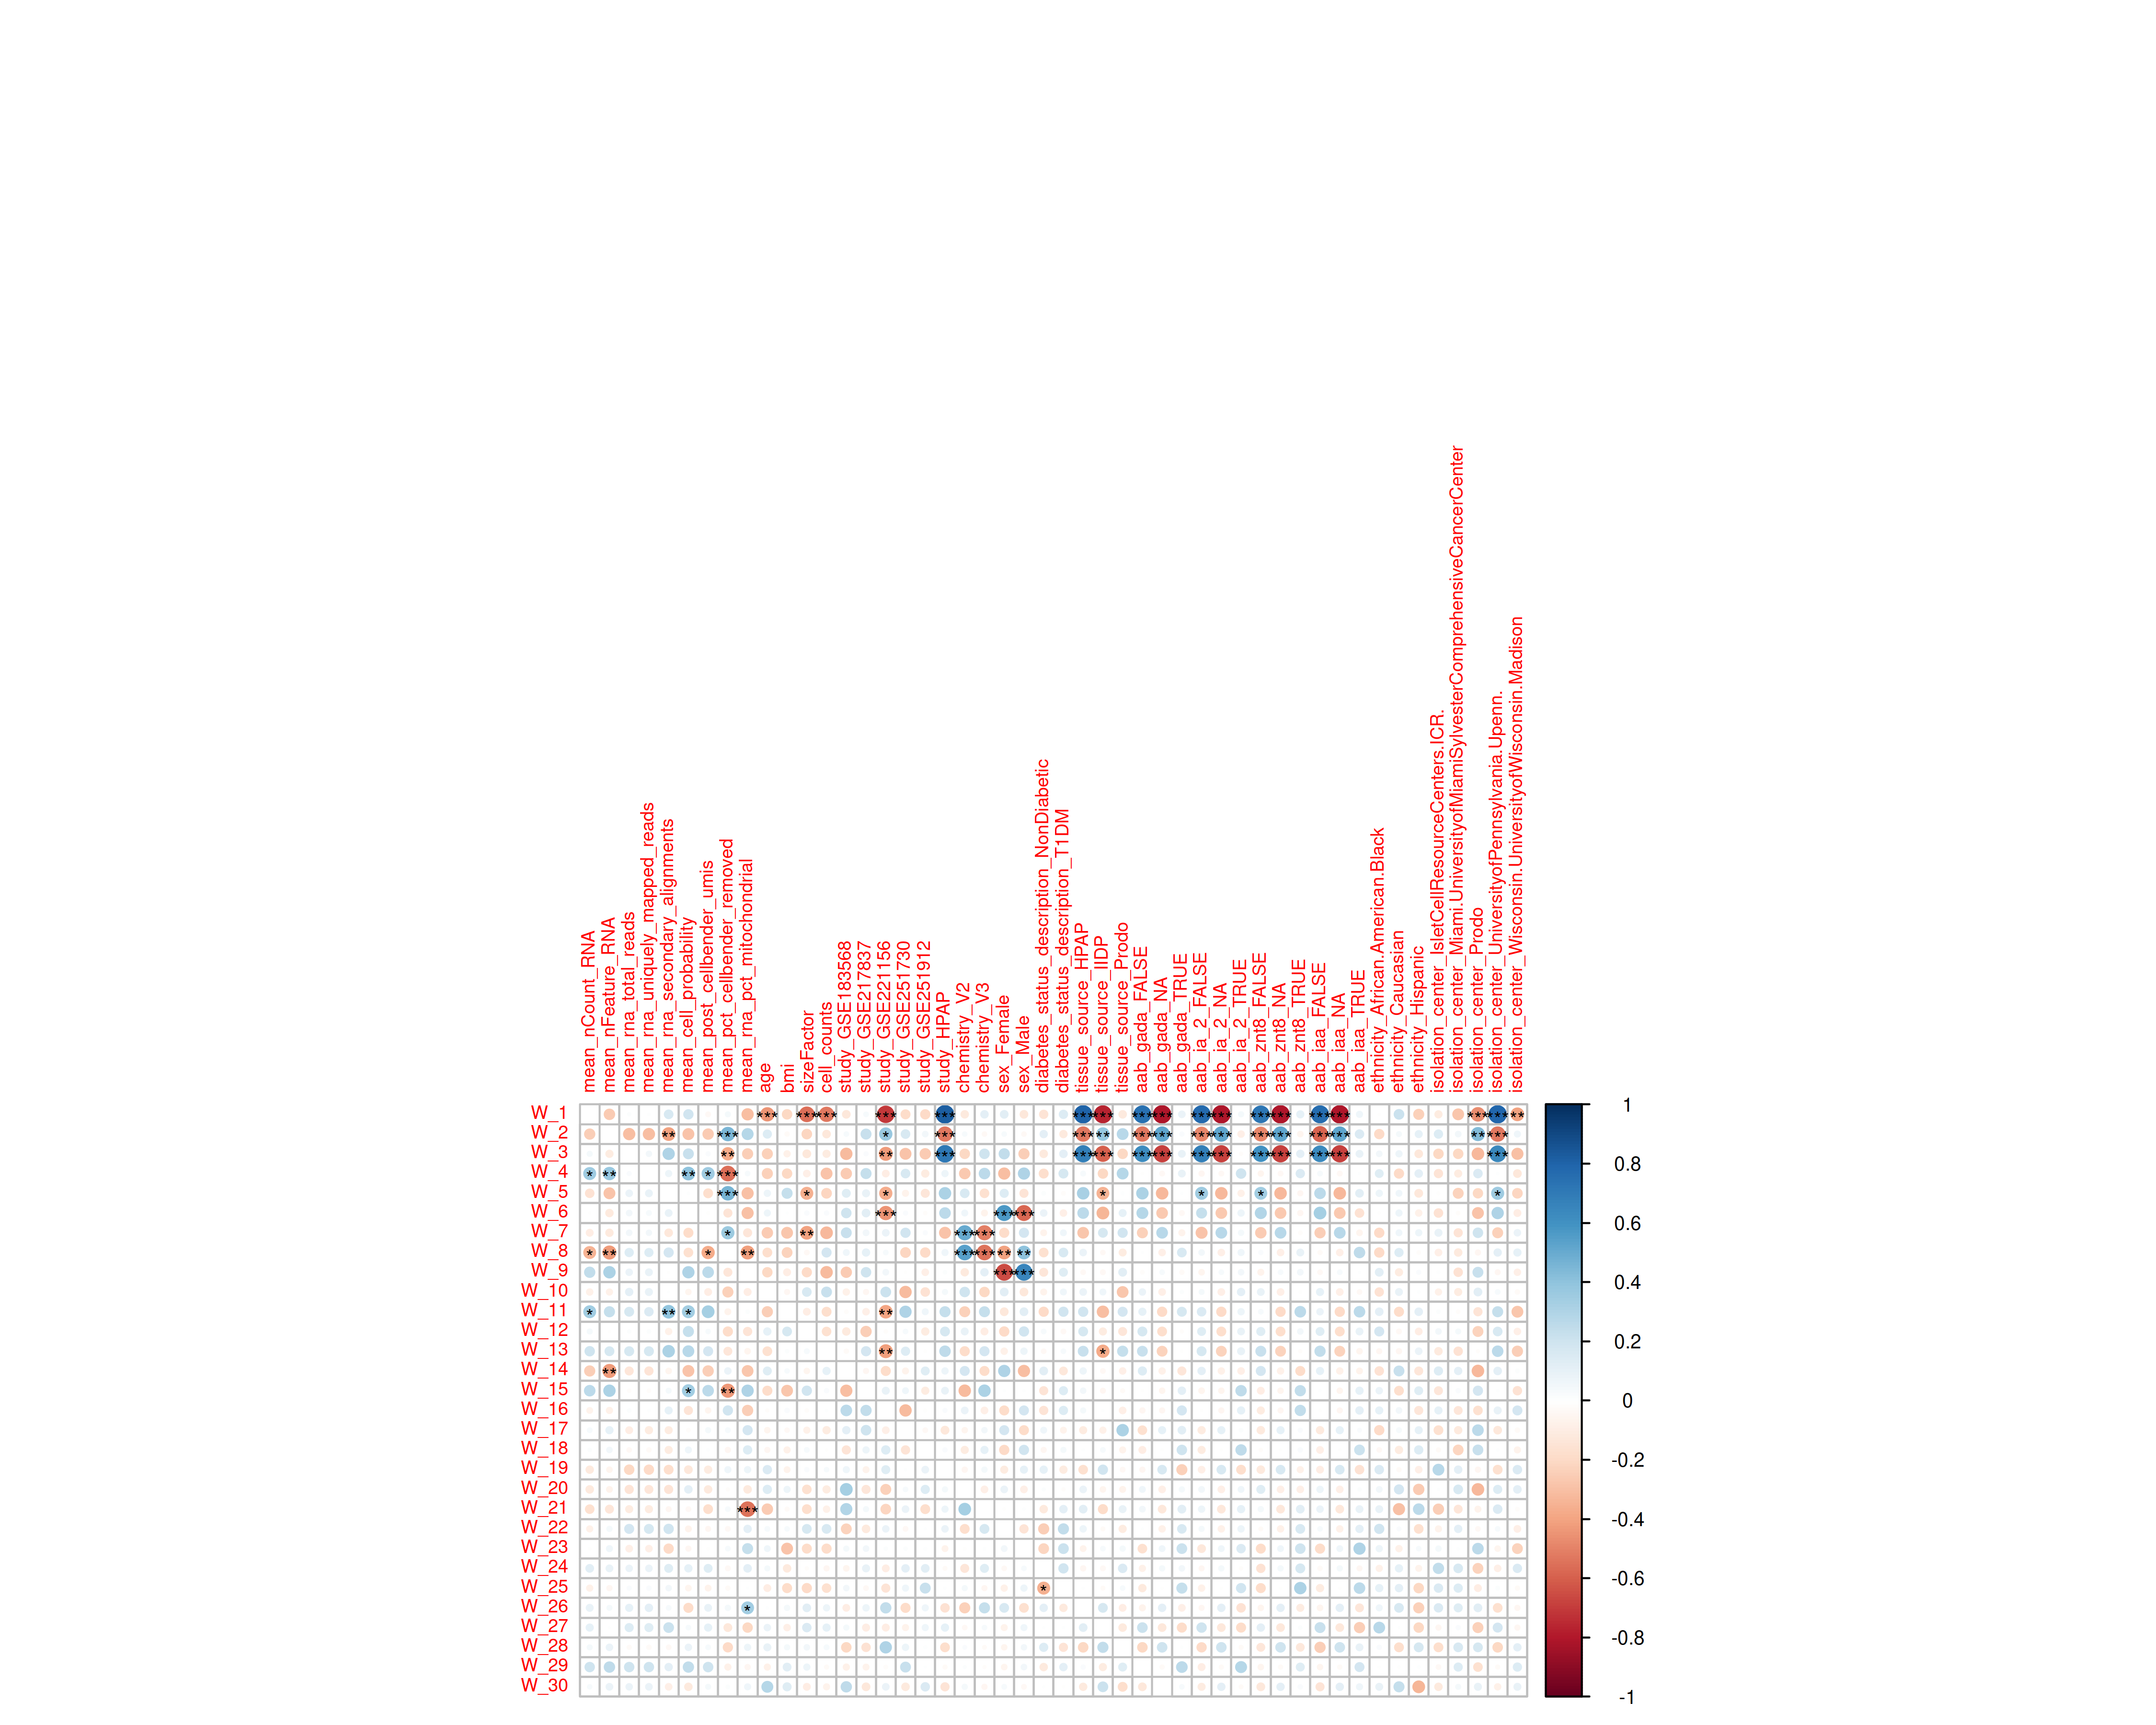

In [14]:
celltype_ruvseq <- readRDS(paste0(input_dir, cell.type, "_celltype_ruvseq.Rds"))

k <- length(celltype_ruvseq)
tmp <- data.frame(celltype_ruvseq[[k]]$W) %>% tibble::rownames_to_column("sample_id")
tmp <- combine_by_sampleid(coldata, tmp)
tmp <- dplyr::select(tmp, -any_of(c("sample_id", "rrid", "samples"))) %>%
    DataExplorer::dummify() %>%
    dplyr::select_if(is_almost_ok, ~.x)
a <- psych::corr.test(tmp[, grep("W_", colnames(tmp))], tmp[, grep("W_|PC", colnames(tmp), invert = T)],
                     use = "na.or.complete", method = "spearman", adjust = "BH")

options(repr.plot.width = 15, repr.plot.height = 12, repr.plot.res = 300)
corrplot::corrplot(a$r, p.mat = a$p.adj, tl.cex = .75, sig.level = c(0.01, 0.05, 0.1), pch.cex = 0.8,
                     insig = "label_sig", diag = FALSE)

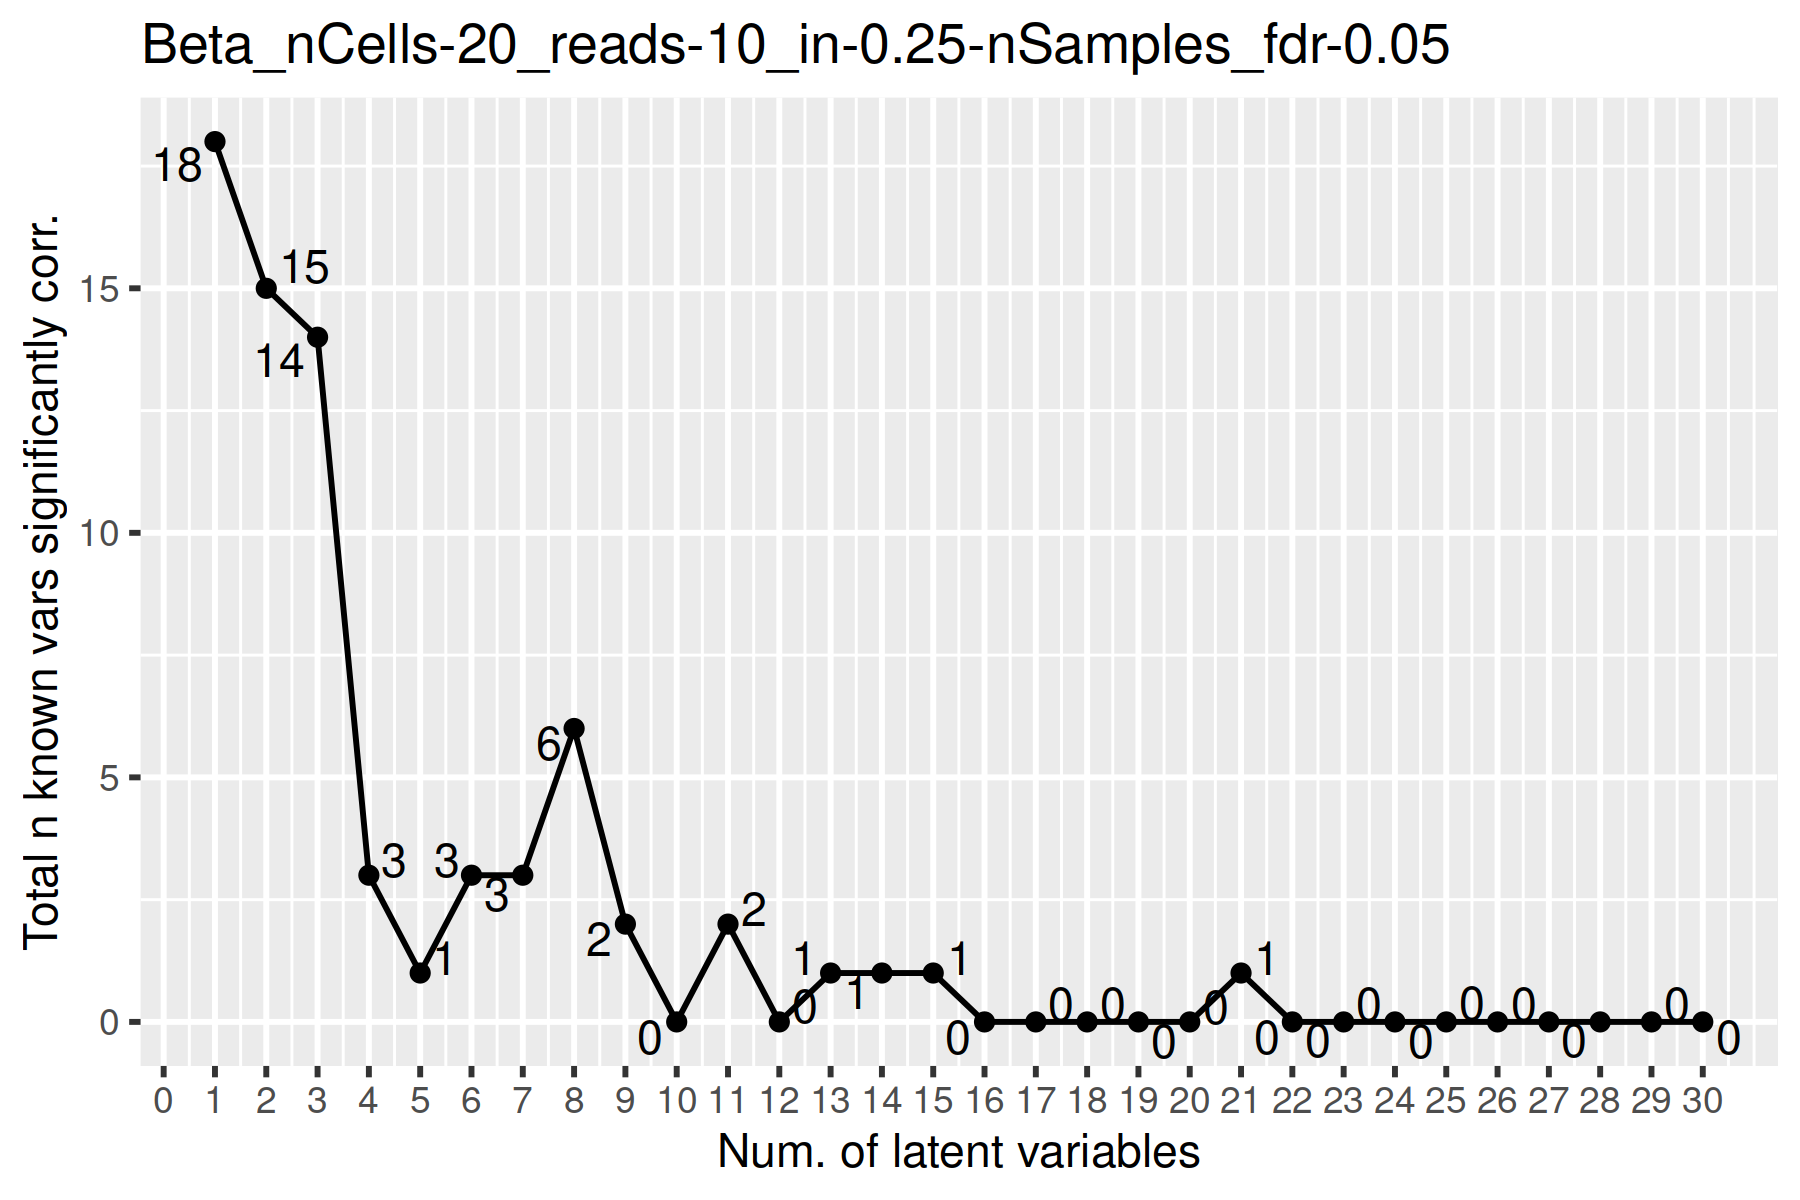

In [15]:
## calculate which k to search
tmp <- rowSums(a$p.adj < 0.05)
tmp <- data.frame(tmp)
tmp$k <- 1:nrow(tmp)
colnames(tmp) <- c("n_known_vars", "k")
k_stop <- tmp[tmp$n_known_vars == 0, "k"][1] # get the smallest k that does not significantly correlate with any known variables

options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)
p <- ggplot(tmp, aes(k, n_known_vars)) + geom_line() +
  geom_point() + ggrepel::geom_text_repel(aes(label = glue("{n_known_vars}")), max.overlaps = Inf, box.padding = 0.1) +
  scale_x_continuous(breaks=seq(0, length(celltype_ruvseq), by=1)) +
  labs(x = 'Num. of latent variables', y = 'Total n known vars significantly corr.',
       title = glue("{cell.type}_nCells-{20}_reads-{10}_in-{1/4}-nSamples_fdr-{0.05}"))
print(p)

In [16]:
k_stop

[1] 10

Choose `k_stop = 10` because as `k = 10` does not correlate with any known covariate.

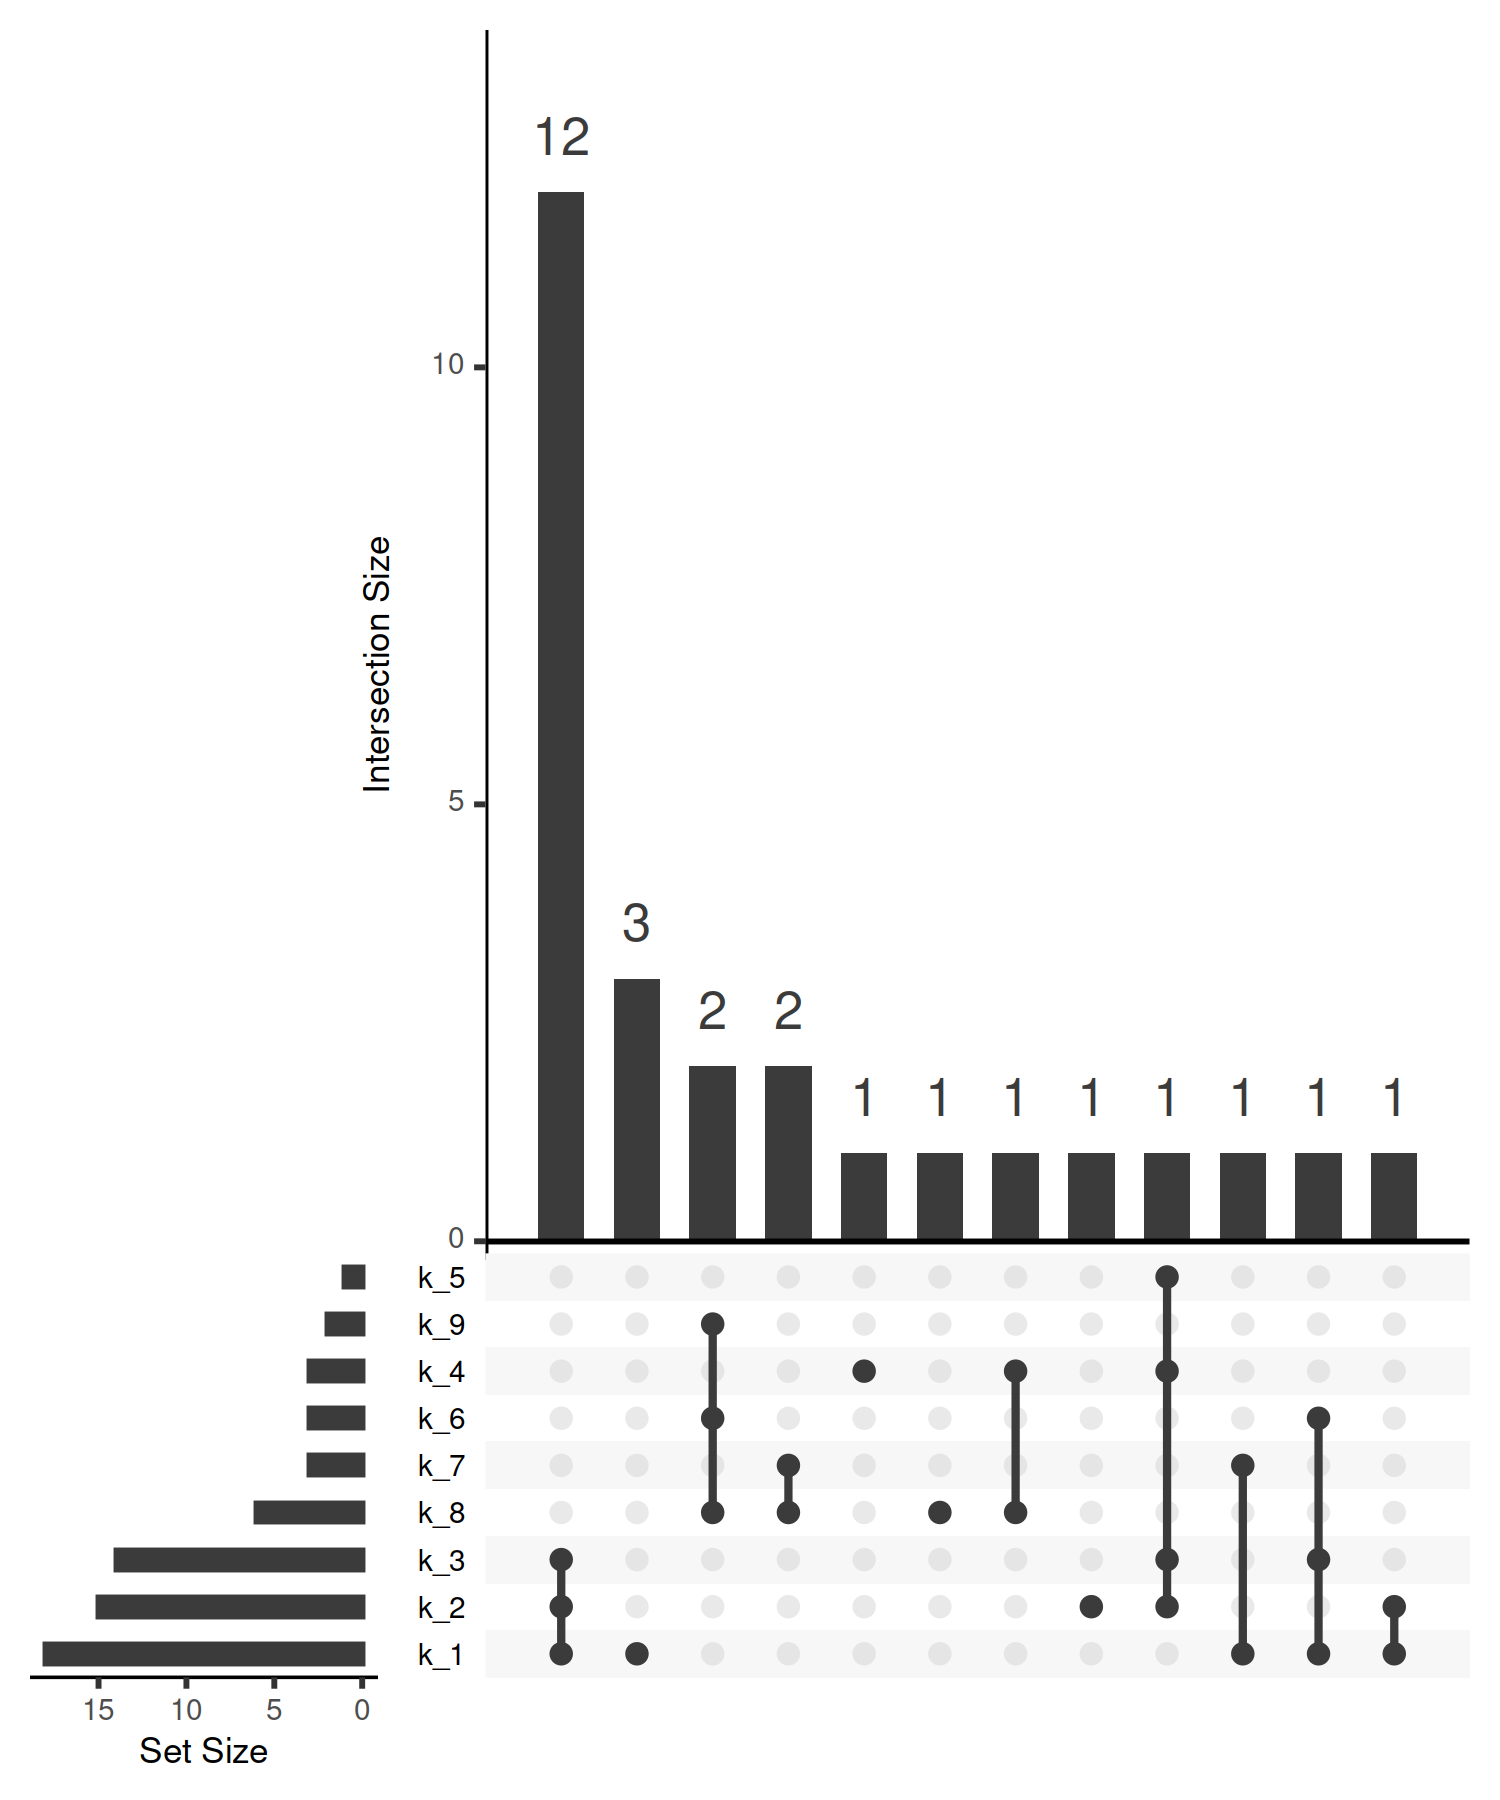

In [17]:
#find which known vars. corr. with latent vars
tmp <- data.frame(a$p.adj < 0.05)[1:(k_stop-1),]
x <- vector(mode = "list", length = length(1:(k_stop-1)))
for (k in 1:(k_stop-1)) {
    j <- which(1:(k_stop-1) == k)
    x[[j]] <- colnames(tmp)[which(tmp[k,] == TRUE)]
}
names(x) <- paste0("k_", 1:(k_stop-1))

library(UpSetR)
options(repr.plot.width = 5, repr.plot.height = 6, repr.plot.res = 300)
p <- upset(fromList(x), order.by = "freq", nsets = 100,
      text.scale = c(1, 1, 1, 1, 1, 2)) #c(intersection size title, intersection size tick labels,
                                        #set size title, set size tick labels, set names, numbers above bars).
print(p)

In [18]:
#choose k
# Function to find the smallest k with a unique element
find_smallest_k_with_unique <- function(lists) {
  k_with_unique <- c()
  all_elements <- unlist(lists)
  unique_elements <- unique(all_elements)
  element_count <- table(all_elements)
  
  for (i in seq_along(lists)) {
    k_elements <- lists[[i]]
    # Find unique elements in the current list
    unique_in_k <- k_elements[k_elements %in% unique_elements[element_count[k_elements] == 1]]
    if (length(unique_in_k) > 0) {
      k_with_unique <- c(k_with_unique, i)
    }
  }
    if (length(k_with_unique) > 0) {
        return(max(k_with_unique))
    } else {
      return(NULL) # Return NULL if no unique element is found
        }
}

if ( length(grep("diabetes", x)) > 0 ) {
    k_chosen <- grep("diabetes", x) - 1
} else {
    k_chosen <- find_smallest_k_with_unique(x)
}
print(k_chosen)

[1] 8


#### Results from `~ diabetes_status_description+sex+age+bmi+ethnicity+chemistry + [8 RUVSeq variables]`

Warning message:
“ggrepel: 929 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


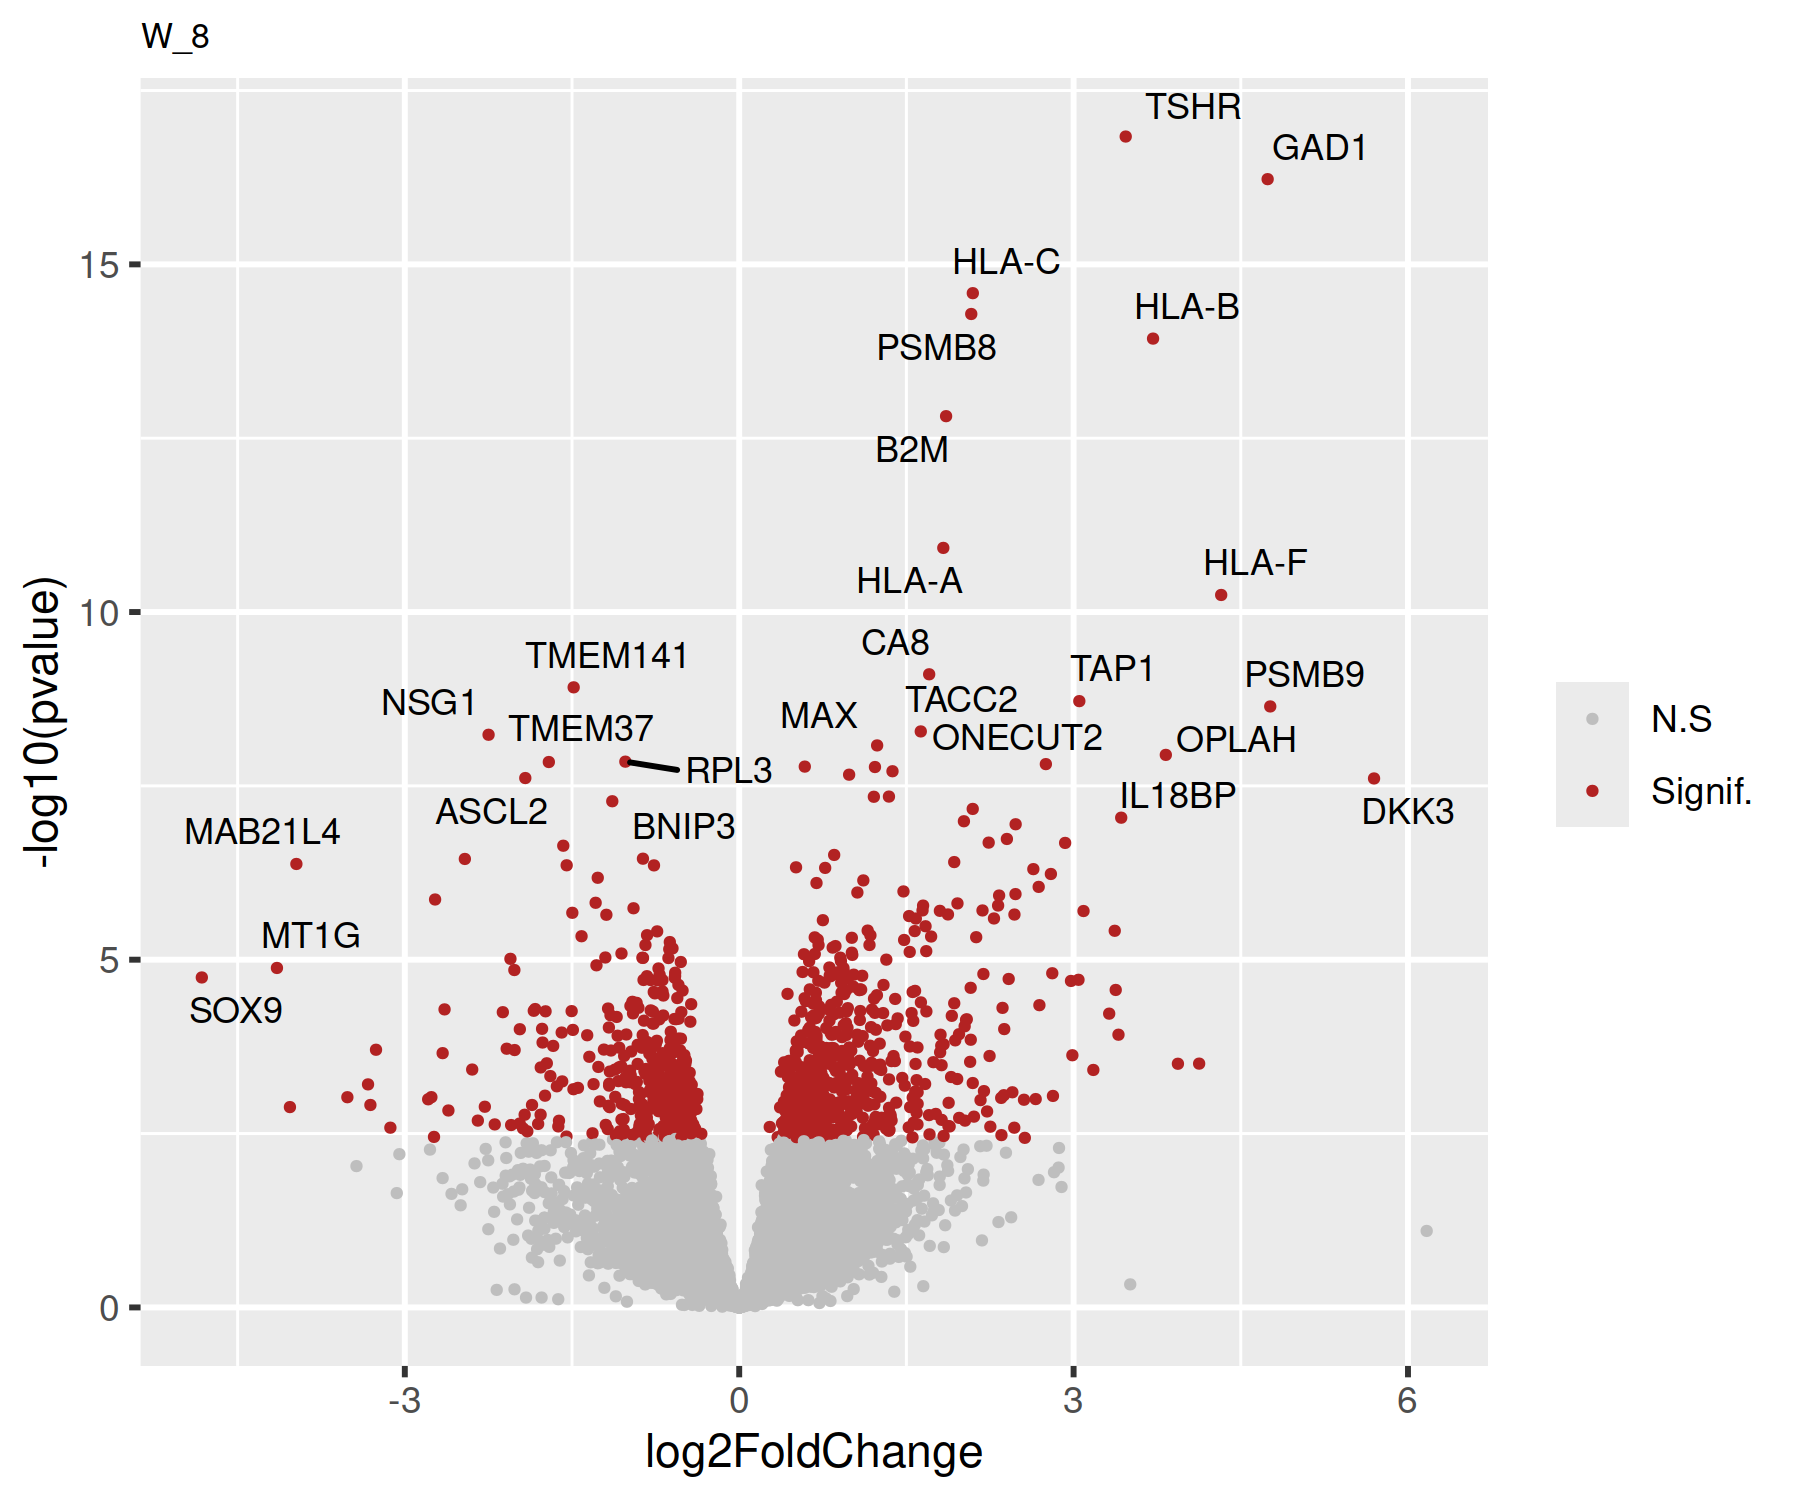

In [20]:
k <- k_chosen
de_object <- celltype_ruvseq[[k]]$de
fdr <- 0.05
xs <- data.frame(de_object$res)
topxs <- tibble::rownames_to_column(xs[which(xs$padj < fdr), ], var = "geneid")
t <- unlist(strsplit(x = de_object$design, "+", fixed = T))

plot <- ggplot(xs, aes(log2FoldChange, -log10(pvalue))) +
        geom_point(aes(col = ifelse(padj < fdr, "Signif.", "N.S")), size = .5) +
        scale_color_manual(values = c("gray", "firebrick")) +
        labs(col = "", title = t[length(t)]) +
        theme(plot.title = element_text(size = 8))
plot <- plot + ggrepel::geom_text_repel(data = topxs, aes(x = log2FoldChange, y = -log10(pvalue), label = geneid), size = 3)
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 300)
print(plot)

Warning message:
“The `.scale` argument of `heatmap()` is deprecated as of tidyHeatmap 1.7.0.
ℹ Please use scale (without dot prefix) instead: heatmap(scale = ...)”
Warning message:
“`add_tile()` was deprecated in tidyHeatmap 1.9.0.
ℹ Please use `annotation_tile()` instead”


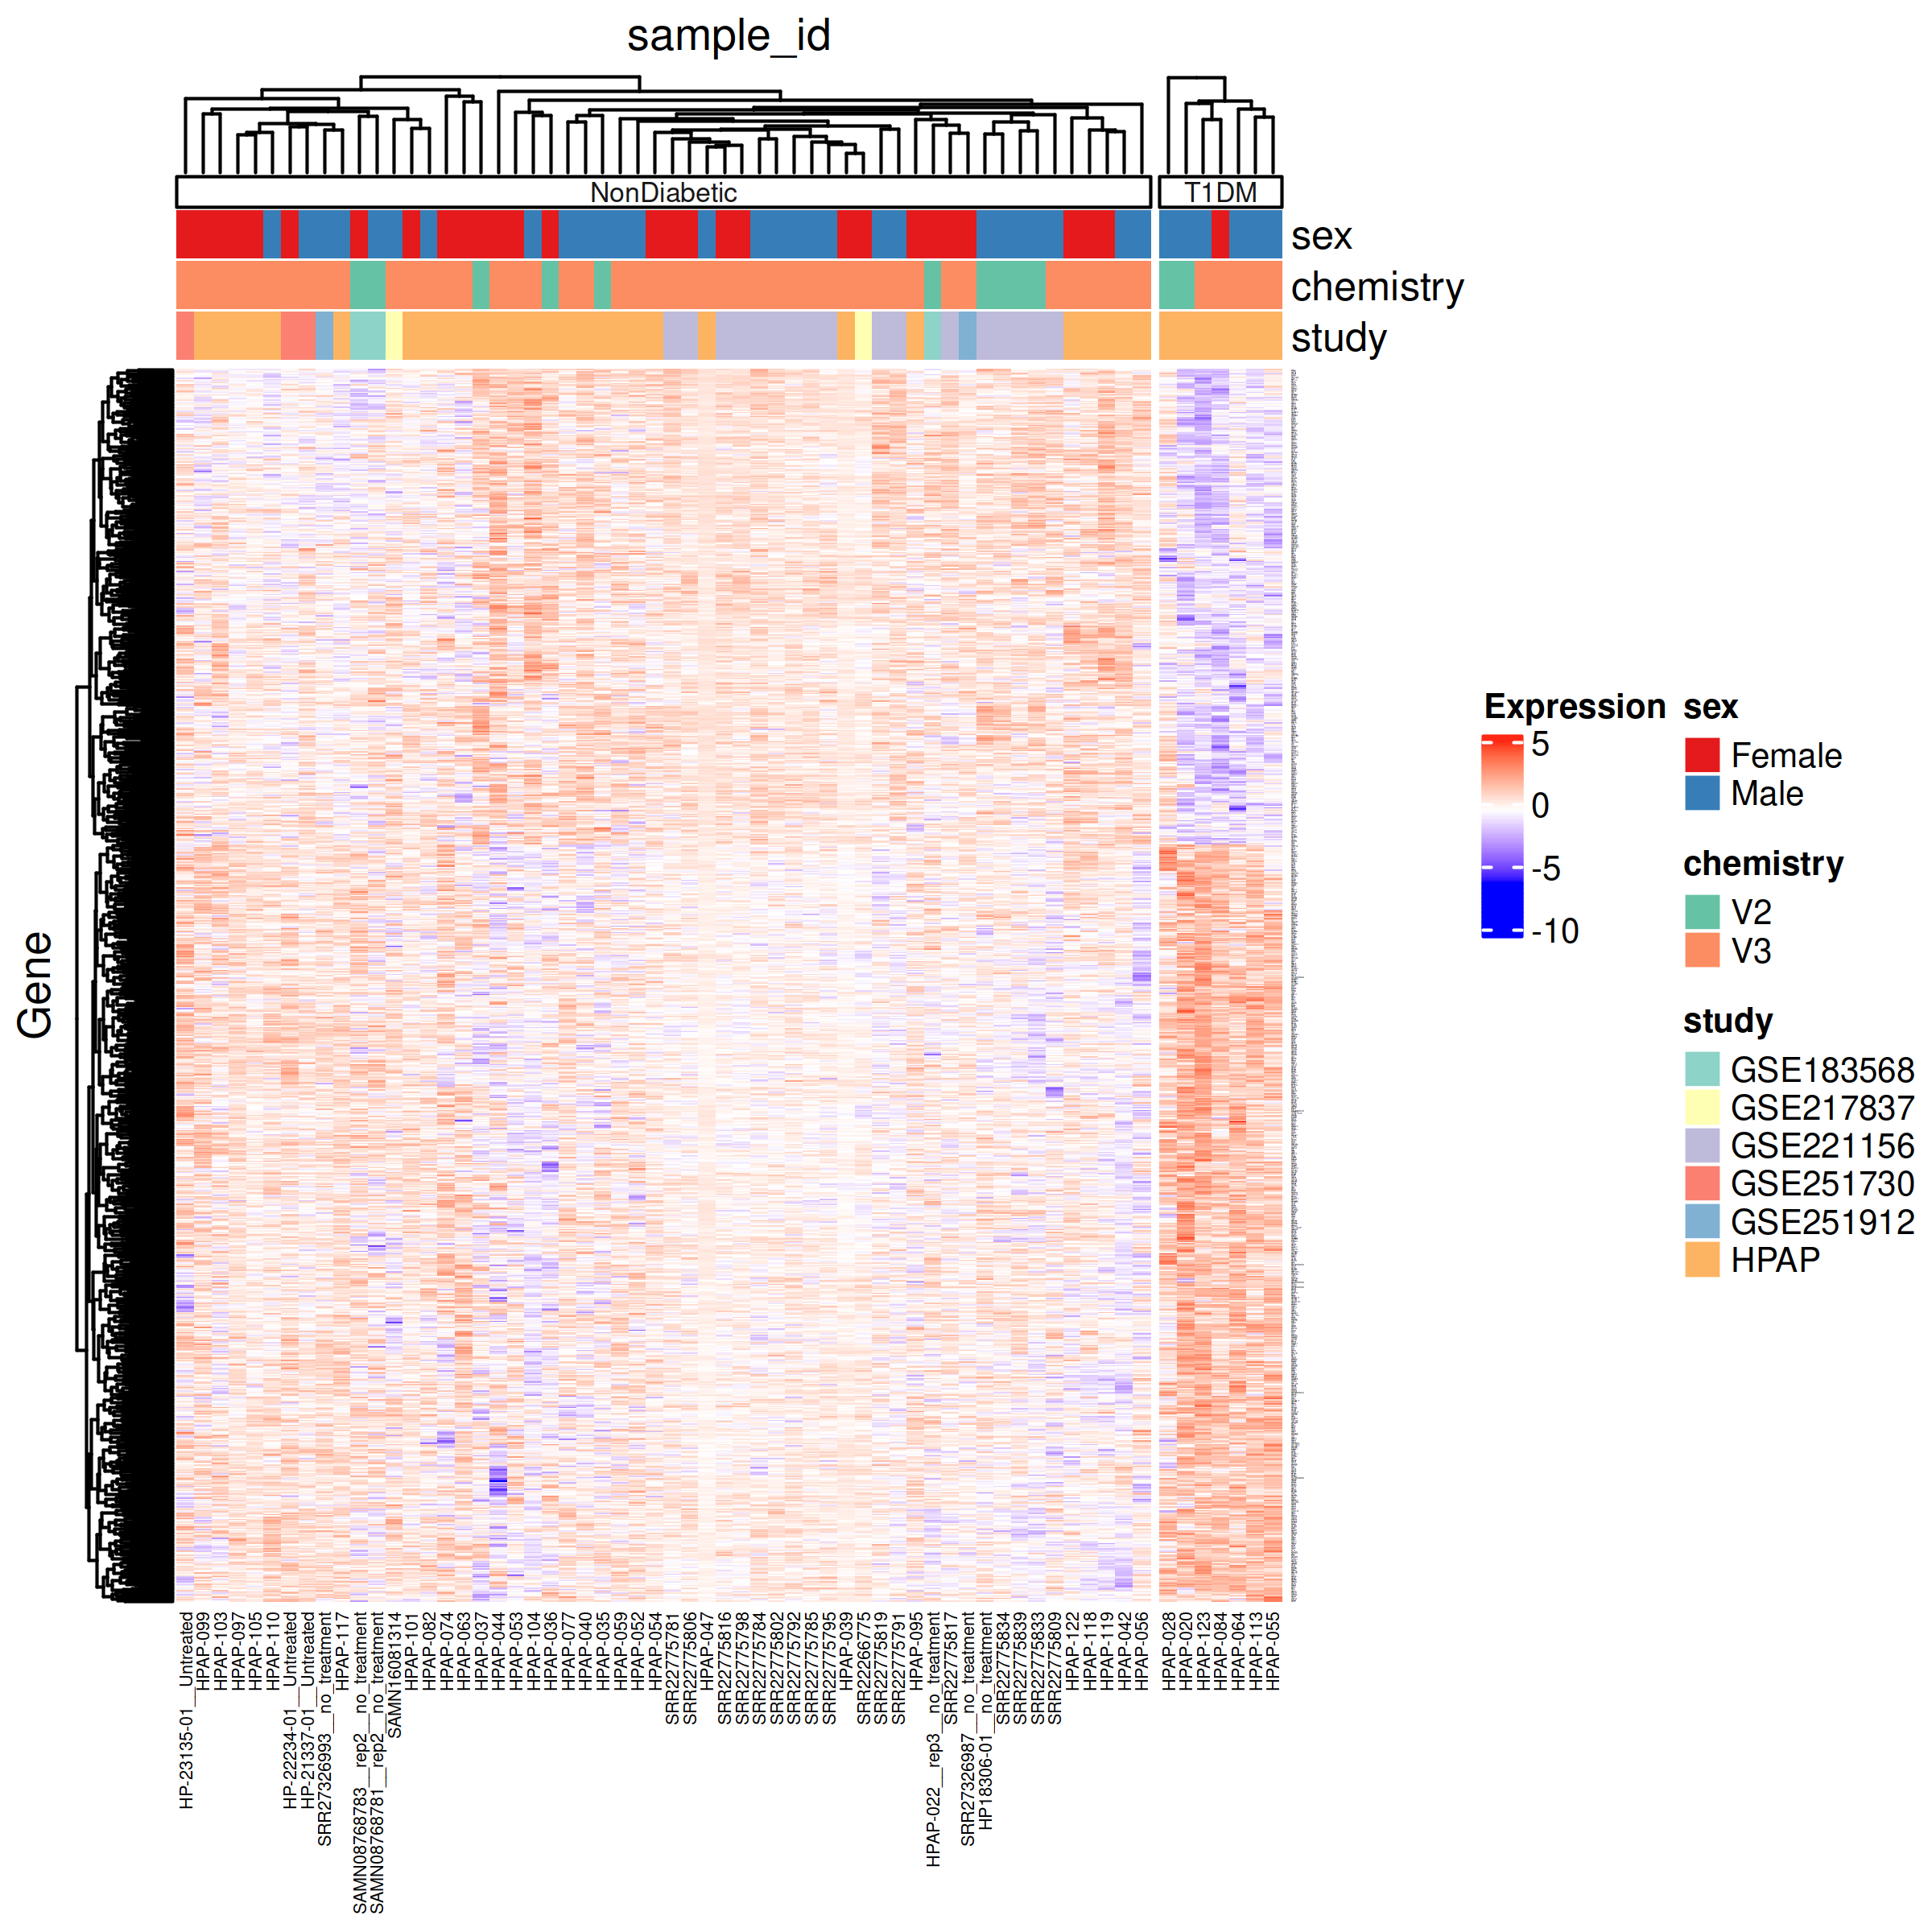

In [34]:
sig.genes <- which(celltype_ruvseq[[k]]$de$res$padj < 0.05)
norm_counts <- as.data.frame(celltype_ruvseq[[k]]$normCounts[sig.genes, ])
norm_counts <- log2(norm_counts+1)
norm_counts$Gene <- rownames(norm_counts)
split_by <- "diabetes_status_description"

meta_cols <- na.omit(c(split_by, "sample_id", "sex", "chemistry", "study"))

options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 300)
print(norm_counts %>%
        dplyr::filter(!is.na(Gene)) %>%
        tidyr::pivot_longer(cols = -c(Gene), names_to = "sample_id", values_to = "Expression") %>%
        dplyr::left_join(., dplyr::select(coldata, any_of(meta_cols)), by = "sample_id") %>%
        { if (!is.na(split_by)) dplyr::group_by(., !!!friendlyeval::treat_strings_as_exprs(split_by)) else . } %>%
        tidyHeatmap::heatmap(
          Gene,
          sample_id,
          Expression,
          .scale = "row",
          palette_value = c("blue", "white", "red")
        ) %>%
        tidyHeatmap::add_tile(sex) %>%
        tidyHeatmap::add_tile(chemistry) %>%
        tidyHeatmap::add_tile(study))

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

Picking joint bandwidth of 0.416



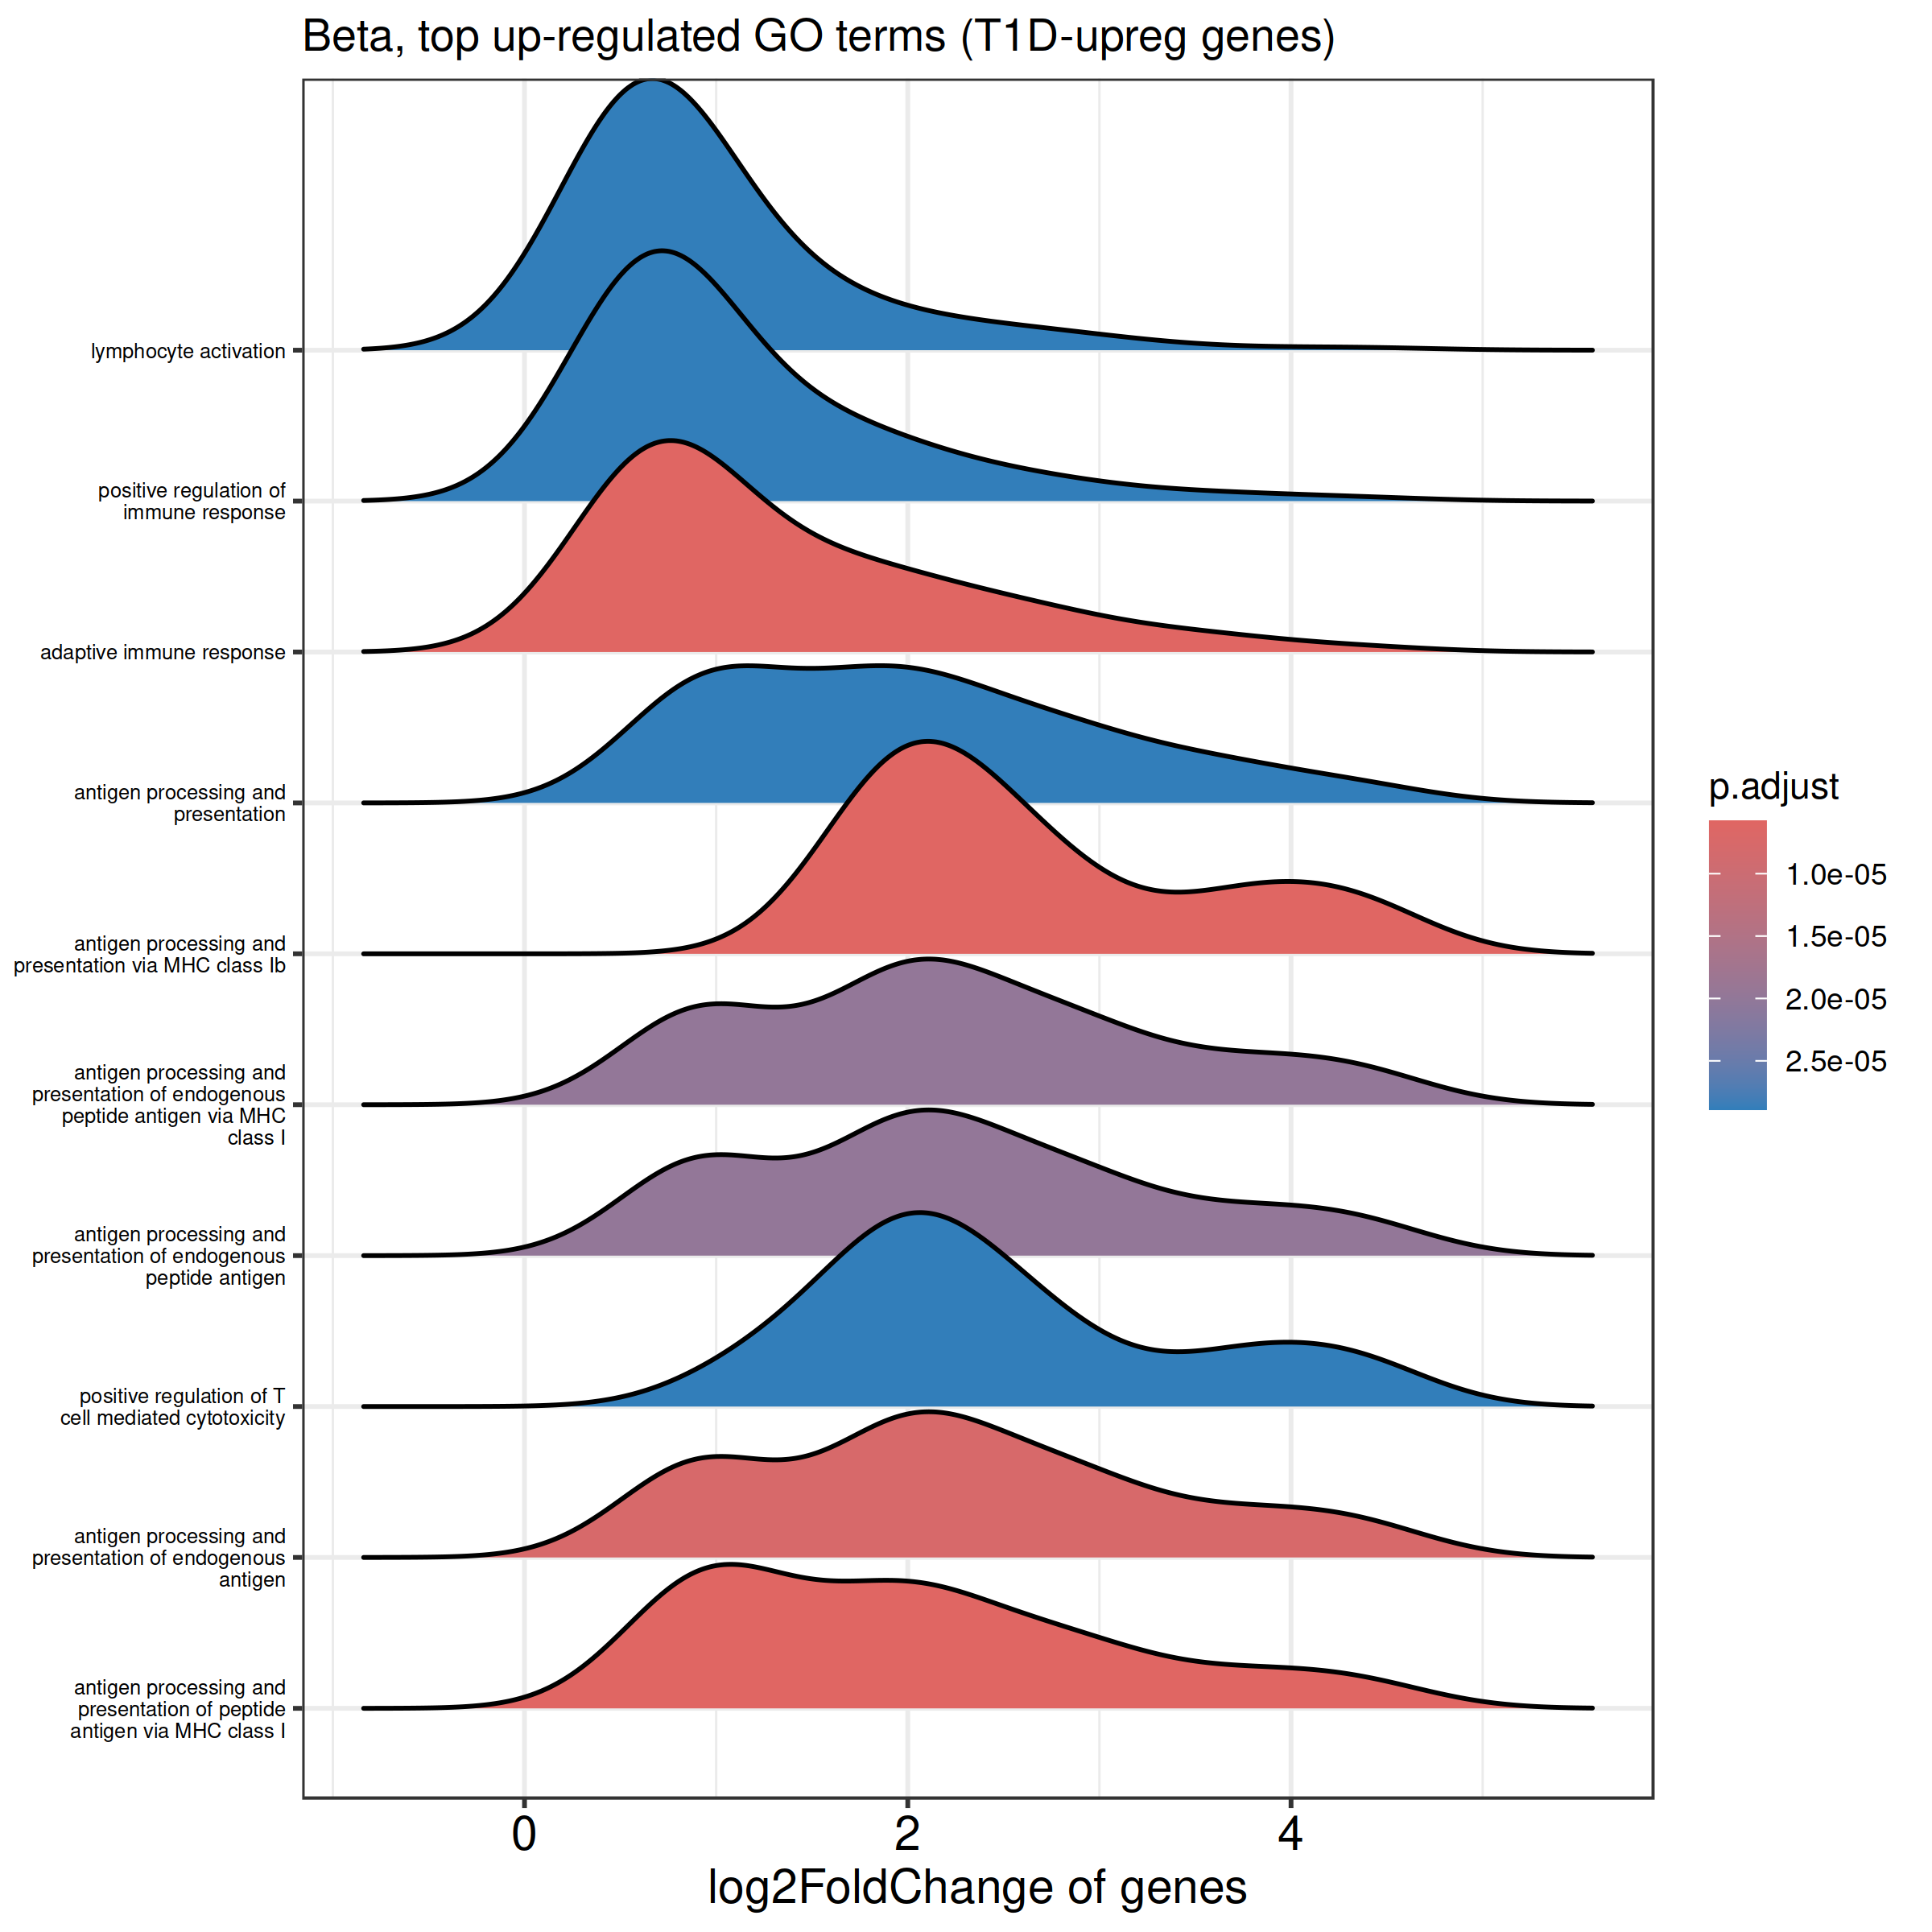

In [35]:
#### go and kegg functions
suppressPackageStartupMessages(library("clusterProfiler"))
library("org.Hs.eg.db")

##### go gsea
tmp <- celltype_ruvseq[[k]]$de$res[!is.na(celltype_ruvseq[[k]]$de$res$padj),]
tmp <- tmp[order(tmp$log2FoldChange, decreasing = T),]
genes <- tmp$log2FoldChange
names(genes) <- rownames(tmp)
kruv <- gseGo(genes)

kruv.df <- data.frame(kruv)
kruv.df <- kruv.df[order(kruv.df$NES, decreasing = T),]
kruv.df$n_genes <- sapply(strsplit(kruv.df$core_enrichment, "/"), function(x) length(unlist(x)))
kruv.df <- kruv.df[kruv.df$p.adjust < 0.05 & kruv.df$n_genes > 5,] 
posNES <- kruv.df[kruv.df$NES > 0,]
if ( nrow(posNES) > 0 ) {
    posNES <- posNES[order(posNES$pvalue, decreasing = F),]
    kruv_to_plot <-  kruv
    kruv@result <- posNES

    p <- enrichplot::ridgeplot(kruv, showCategory = 10, decreasing = T) + 
        theme(axis.text.y = element_text(size = 6)) + xlab("log2FoldChange of genes") +
        ggtitle(paste0(cell.type, ", top up-regulated GO terms (T1D-upreg genes)"))
    print(p)
} else {
    print("no significant terms with NES positive GO")
} 

Picking joint bandwidth of 0.138



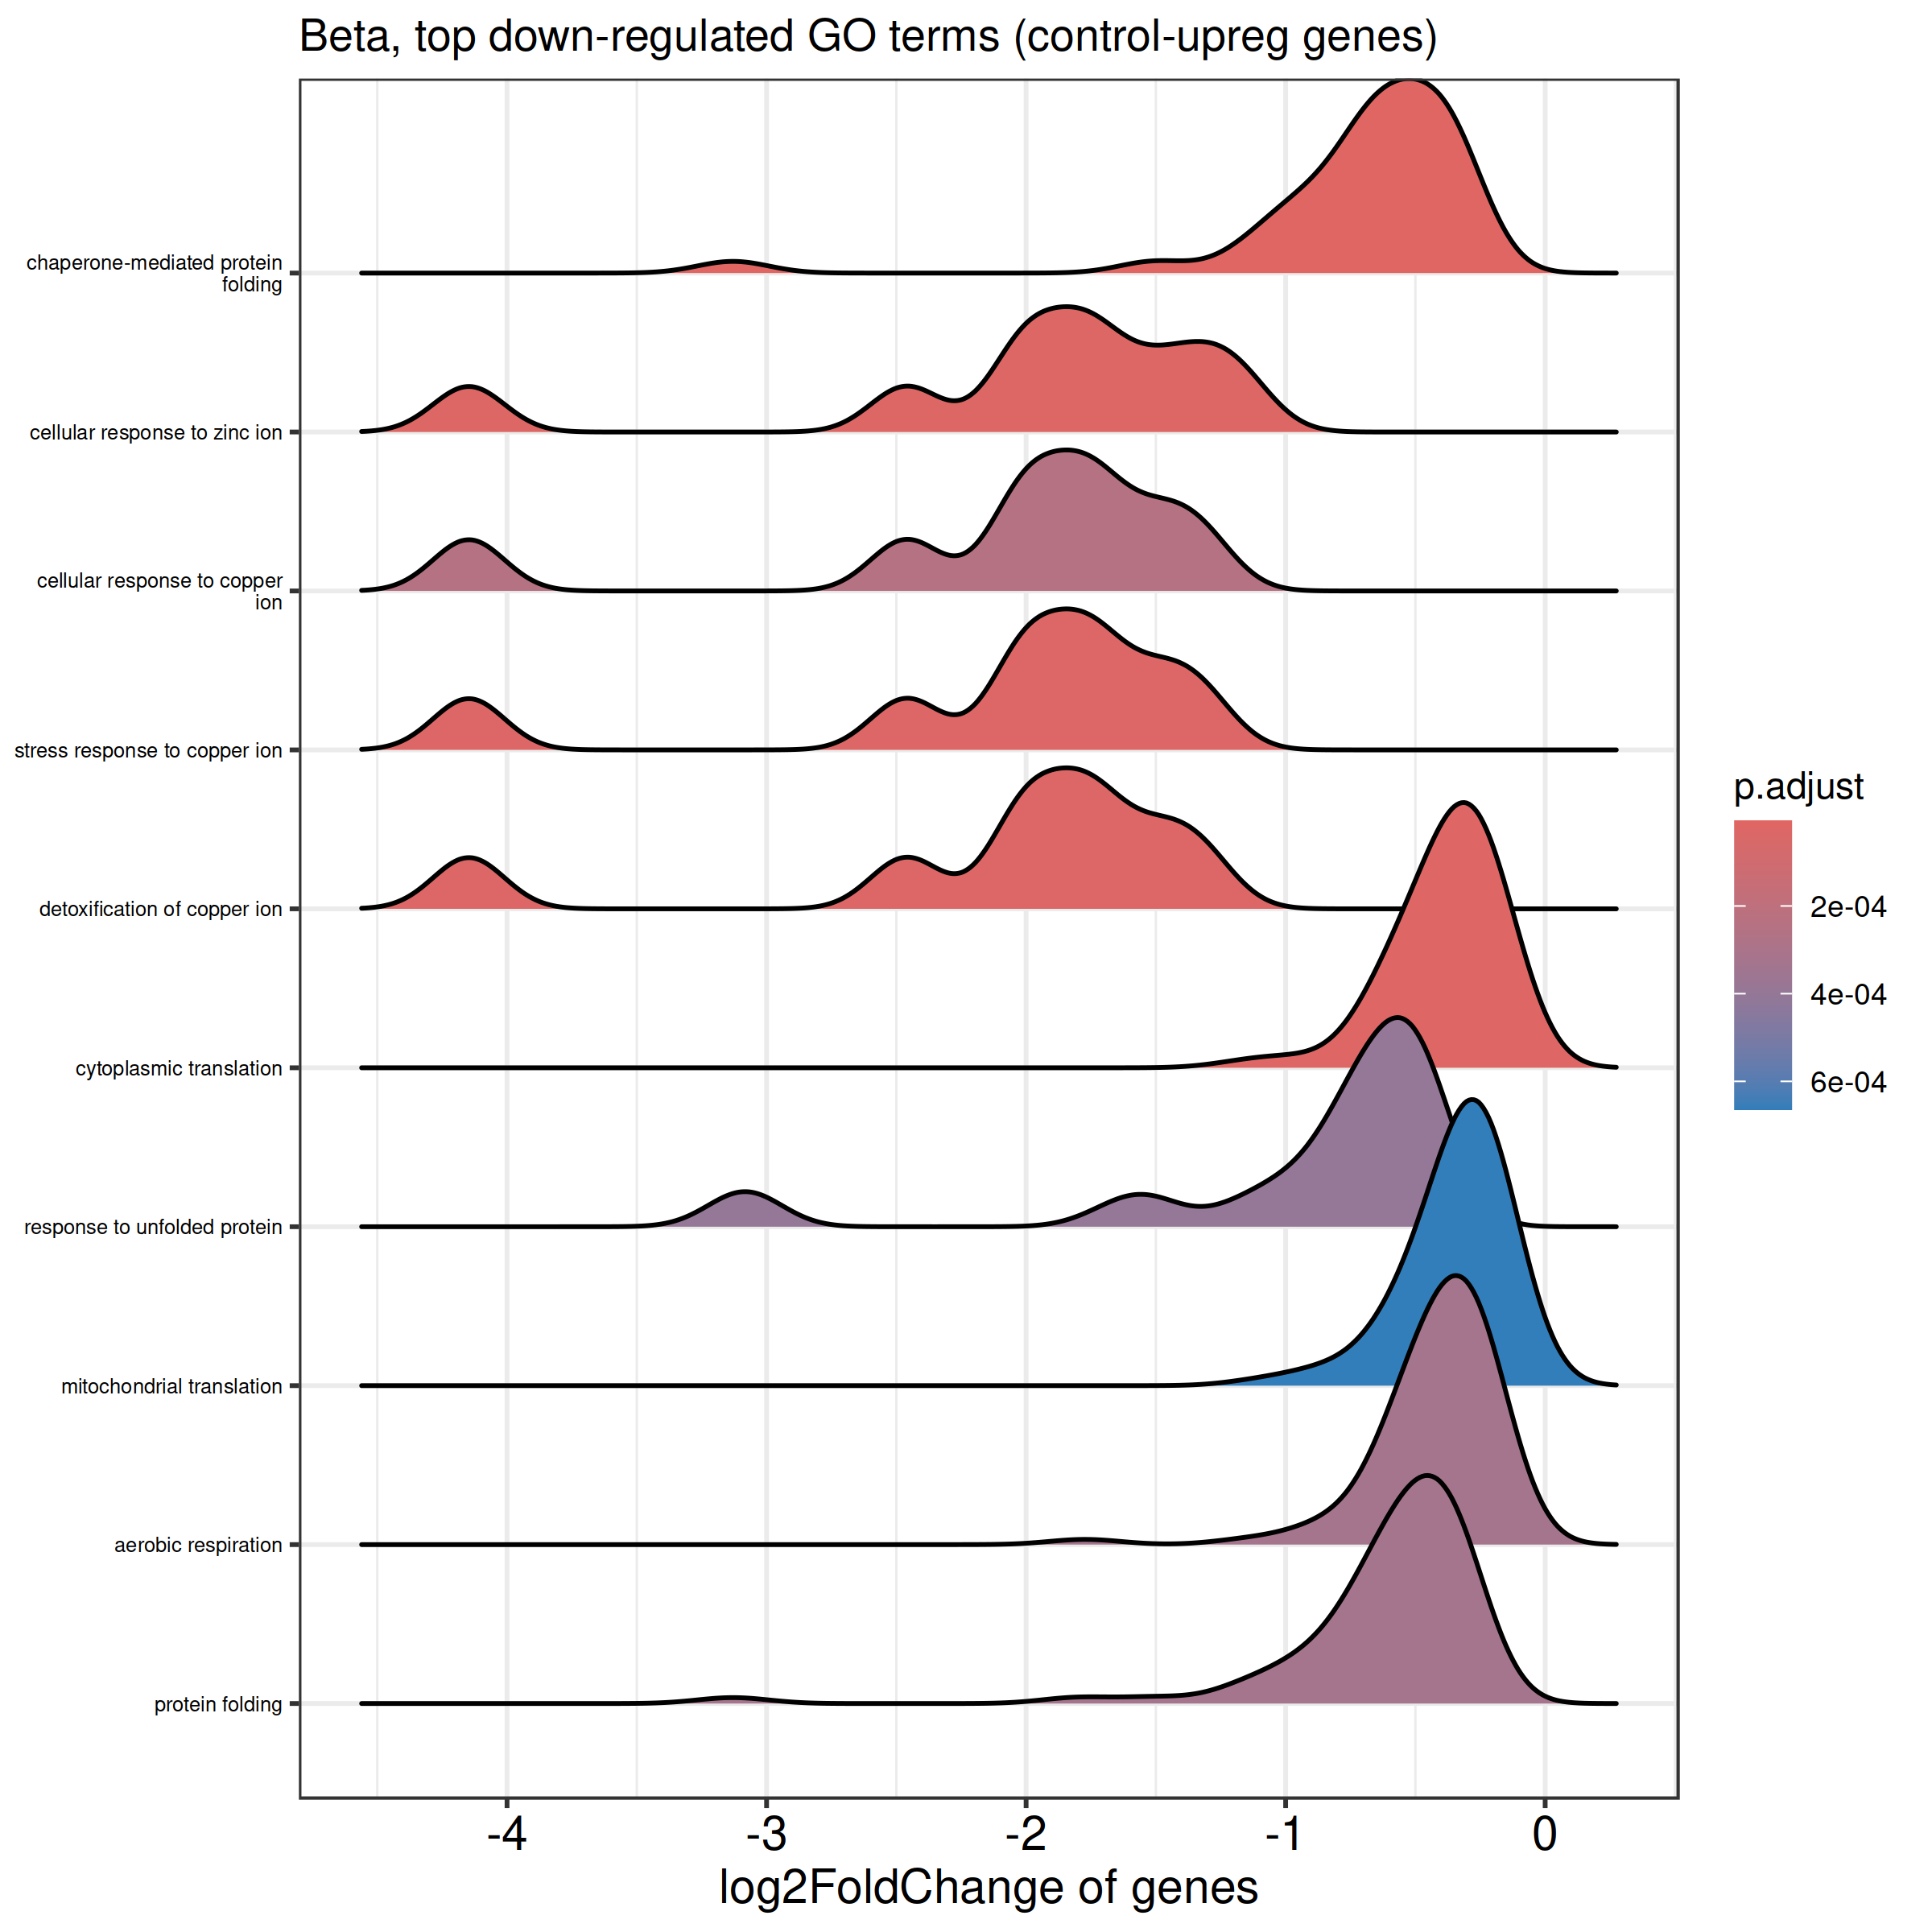

In [36]:
negNES <- kruv.df[kruv.df$NES < 0,]
if ( nrow(negNES) > 0 ) {
negNES <- negNES[order(negNES$pvalue, decreasing = F),]
kruv_to_plot <-  kruv
kruv@result <- negNES

p <- enrichplot::ridgeplot(kruv, showCategory = 10, decreasing = T) + 
    theme(axis.text.y = element_text(size = 6)) + xlab("log2FoldChange of genes") +
    ggtitle(paste0(cell.type, ", top down-regulated GO terms (control-upreg genes)"))
print(p)
} else {
    print("no significant terms with NES negative GO")
}

'select()' returned 1:many mapping between keys and columns

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...

Picking joint bandwidth of 0.482



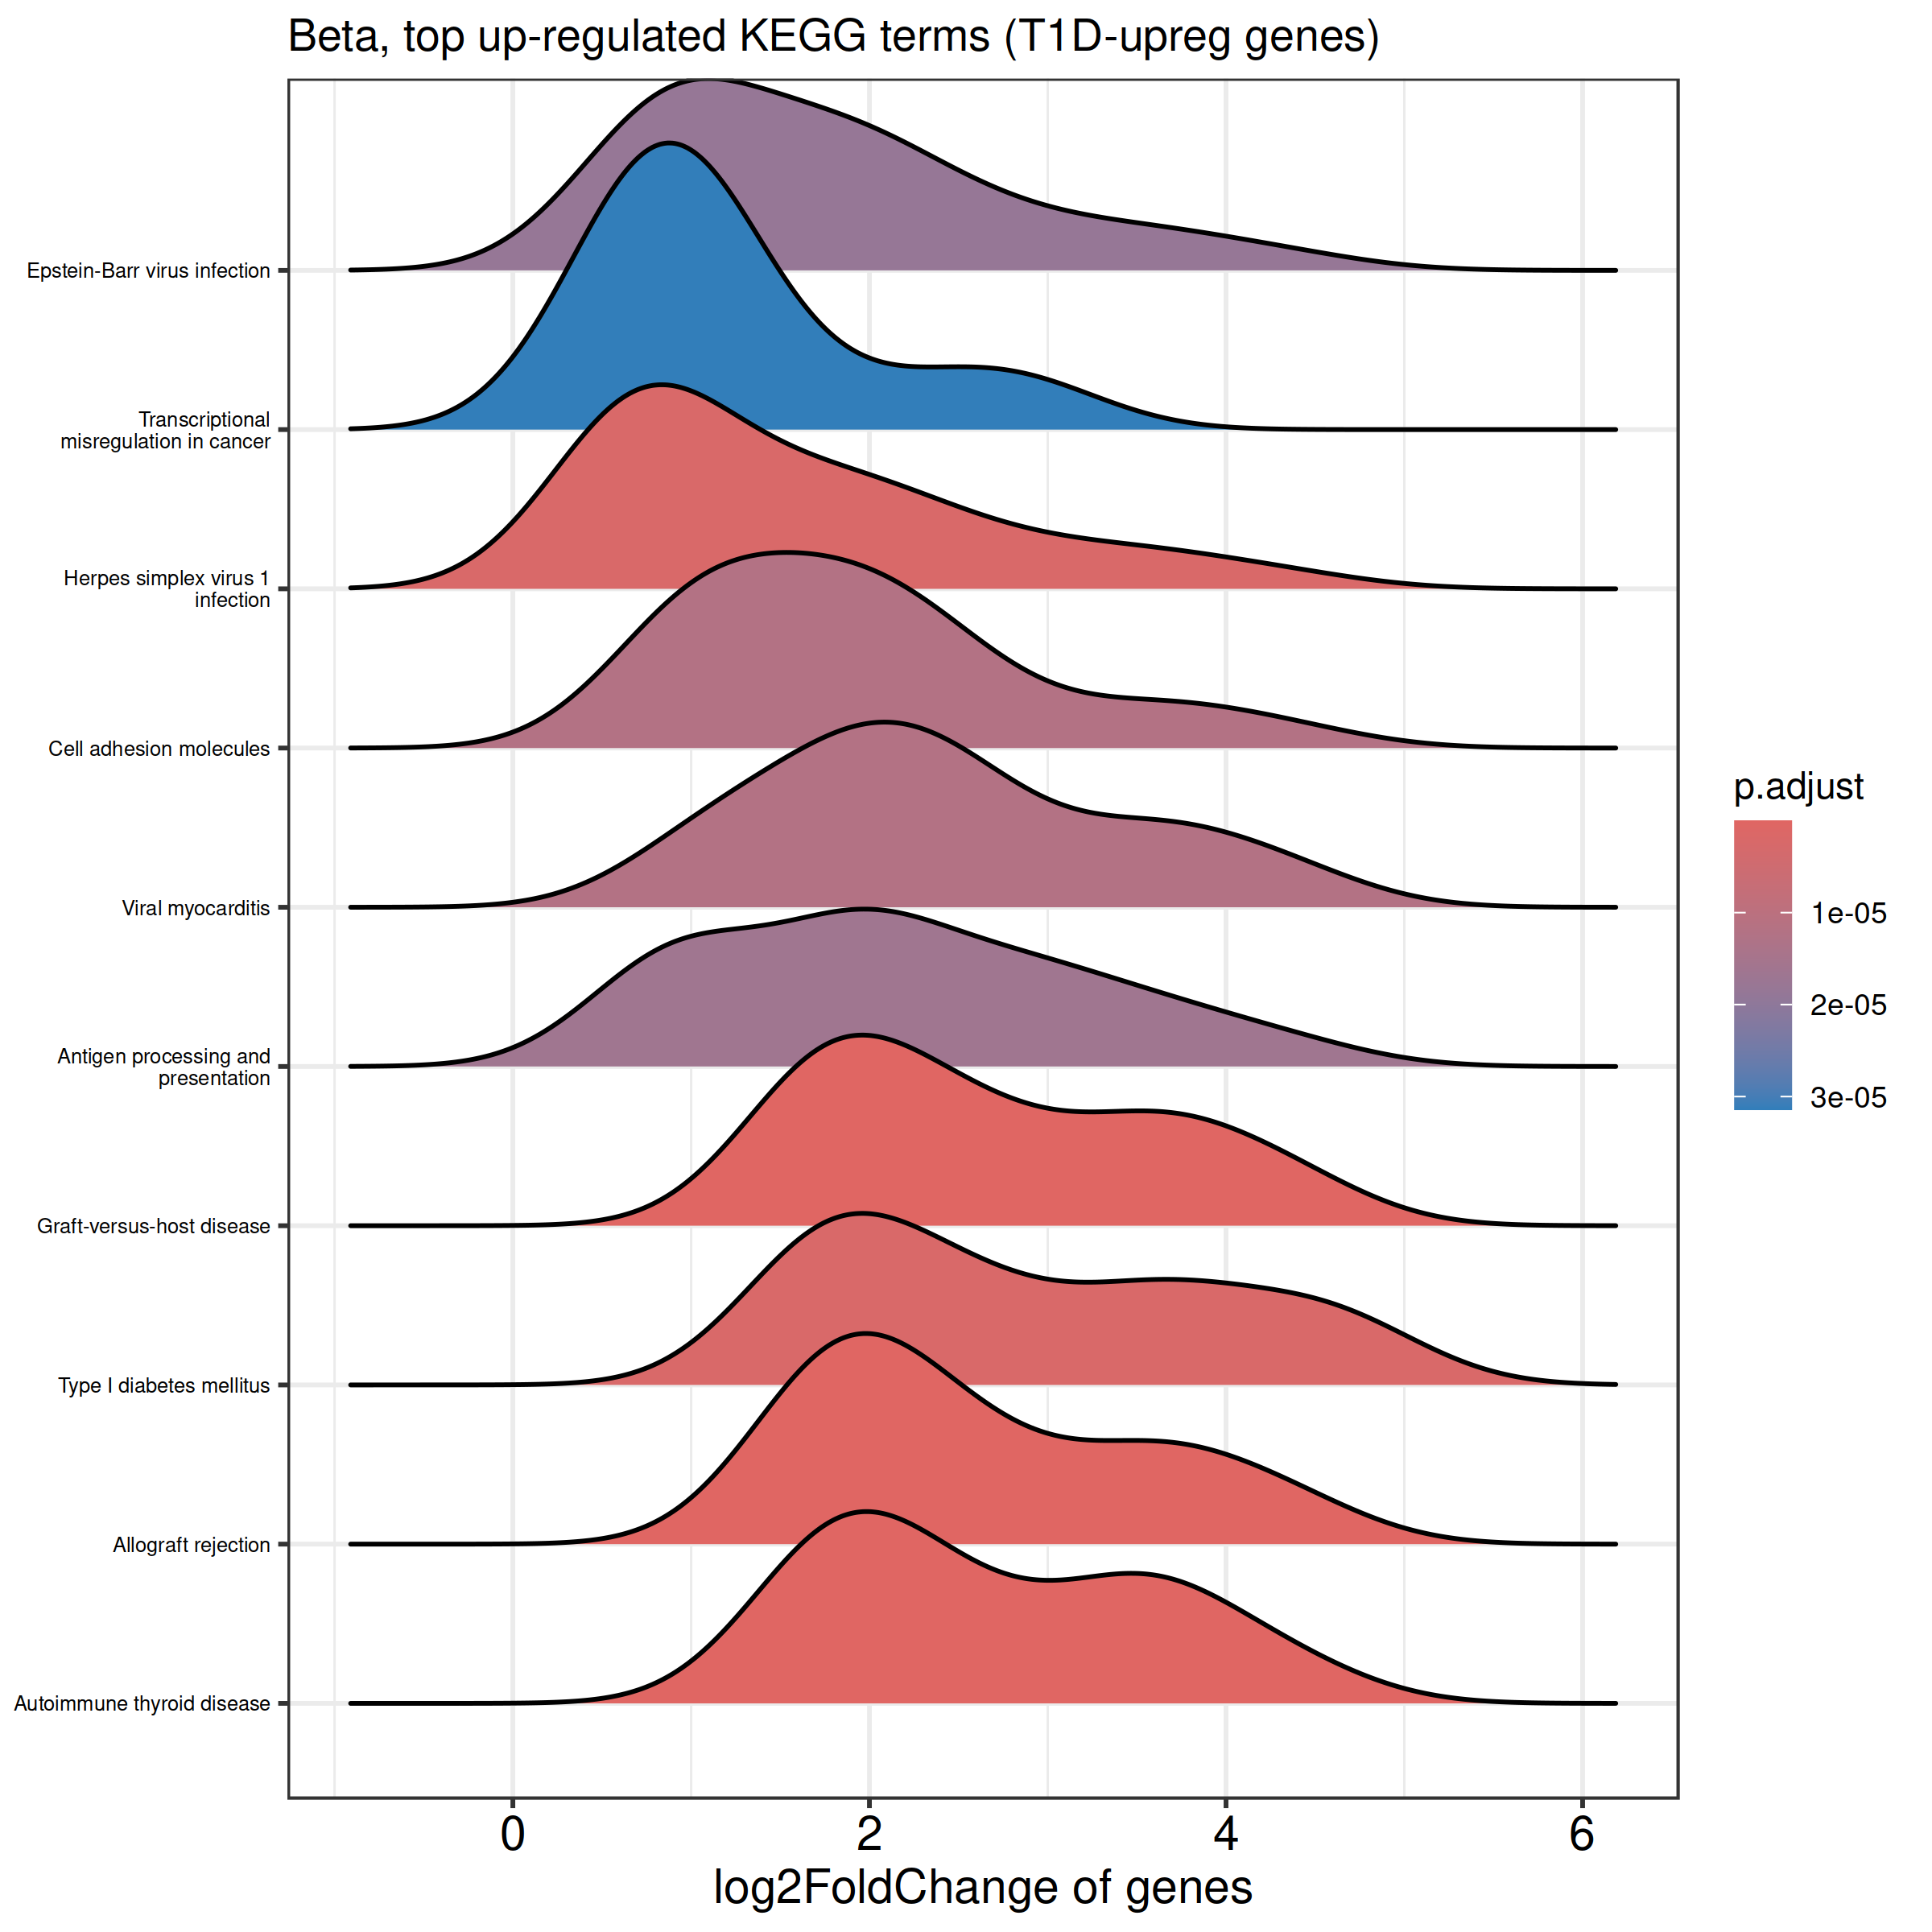

In [37]:
### kegg gsea
tmp <- celltype_ruvseq[[k]]$de$res[!is.na(celltype_ruvseq[[k]]$de$res$padj),]
tmp <- tmp[order(tmp$log2FoldChange, decreasing = T),]
genes <- tmp$log2FoldChange
names(genes) <- rownames(tmp)
kruv <- gseKegg(genes)

kruv.df <- data.frame(kruv)
kruv.df <- kruv.df[order(kruv.df$NES, decreasing = T),]
kruv.df$n_genes <- sapply(strsplit(kruv.df$core_enrichment, "/"), function(x) length(unlist(x)))
kruv.df <- kruv.df[kruv.df$p.adjust < 0.05 & kruv.df$n_genes > 5,] 
posNES <- kruv.df[kruv.df$NES > 0,]
if ( nrow(posNES) > 0 ) {
    posNES <- posNES[order(posNES$pvalue, decreasing = F),]
    kruv_to_plot <-  kruv
    kruv@result <- posNES
    p <- enrichplot::ridgeplot(kruv, showCategory = 10, decreasing = T) + 
        theme(axis.text.y = element_text(size = 6)) + xlab("log2FoldChange of genes") +
        ggtitle(paste0(cell.type, ", top up-regulated KEGG terms (T1D-upreg genes)"))
    print(p)
    } else {
        print("no significant terms with NES positive KEGG")
}

Picking joint bandwidth of 0.155



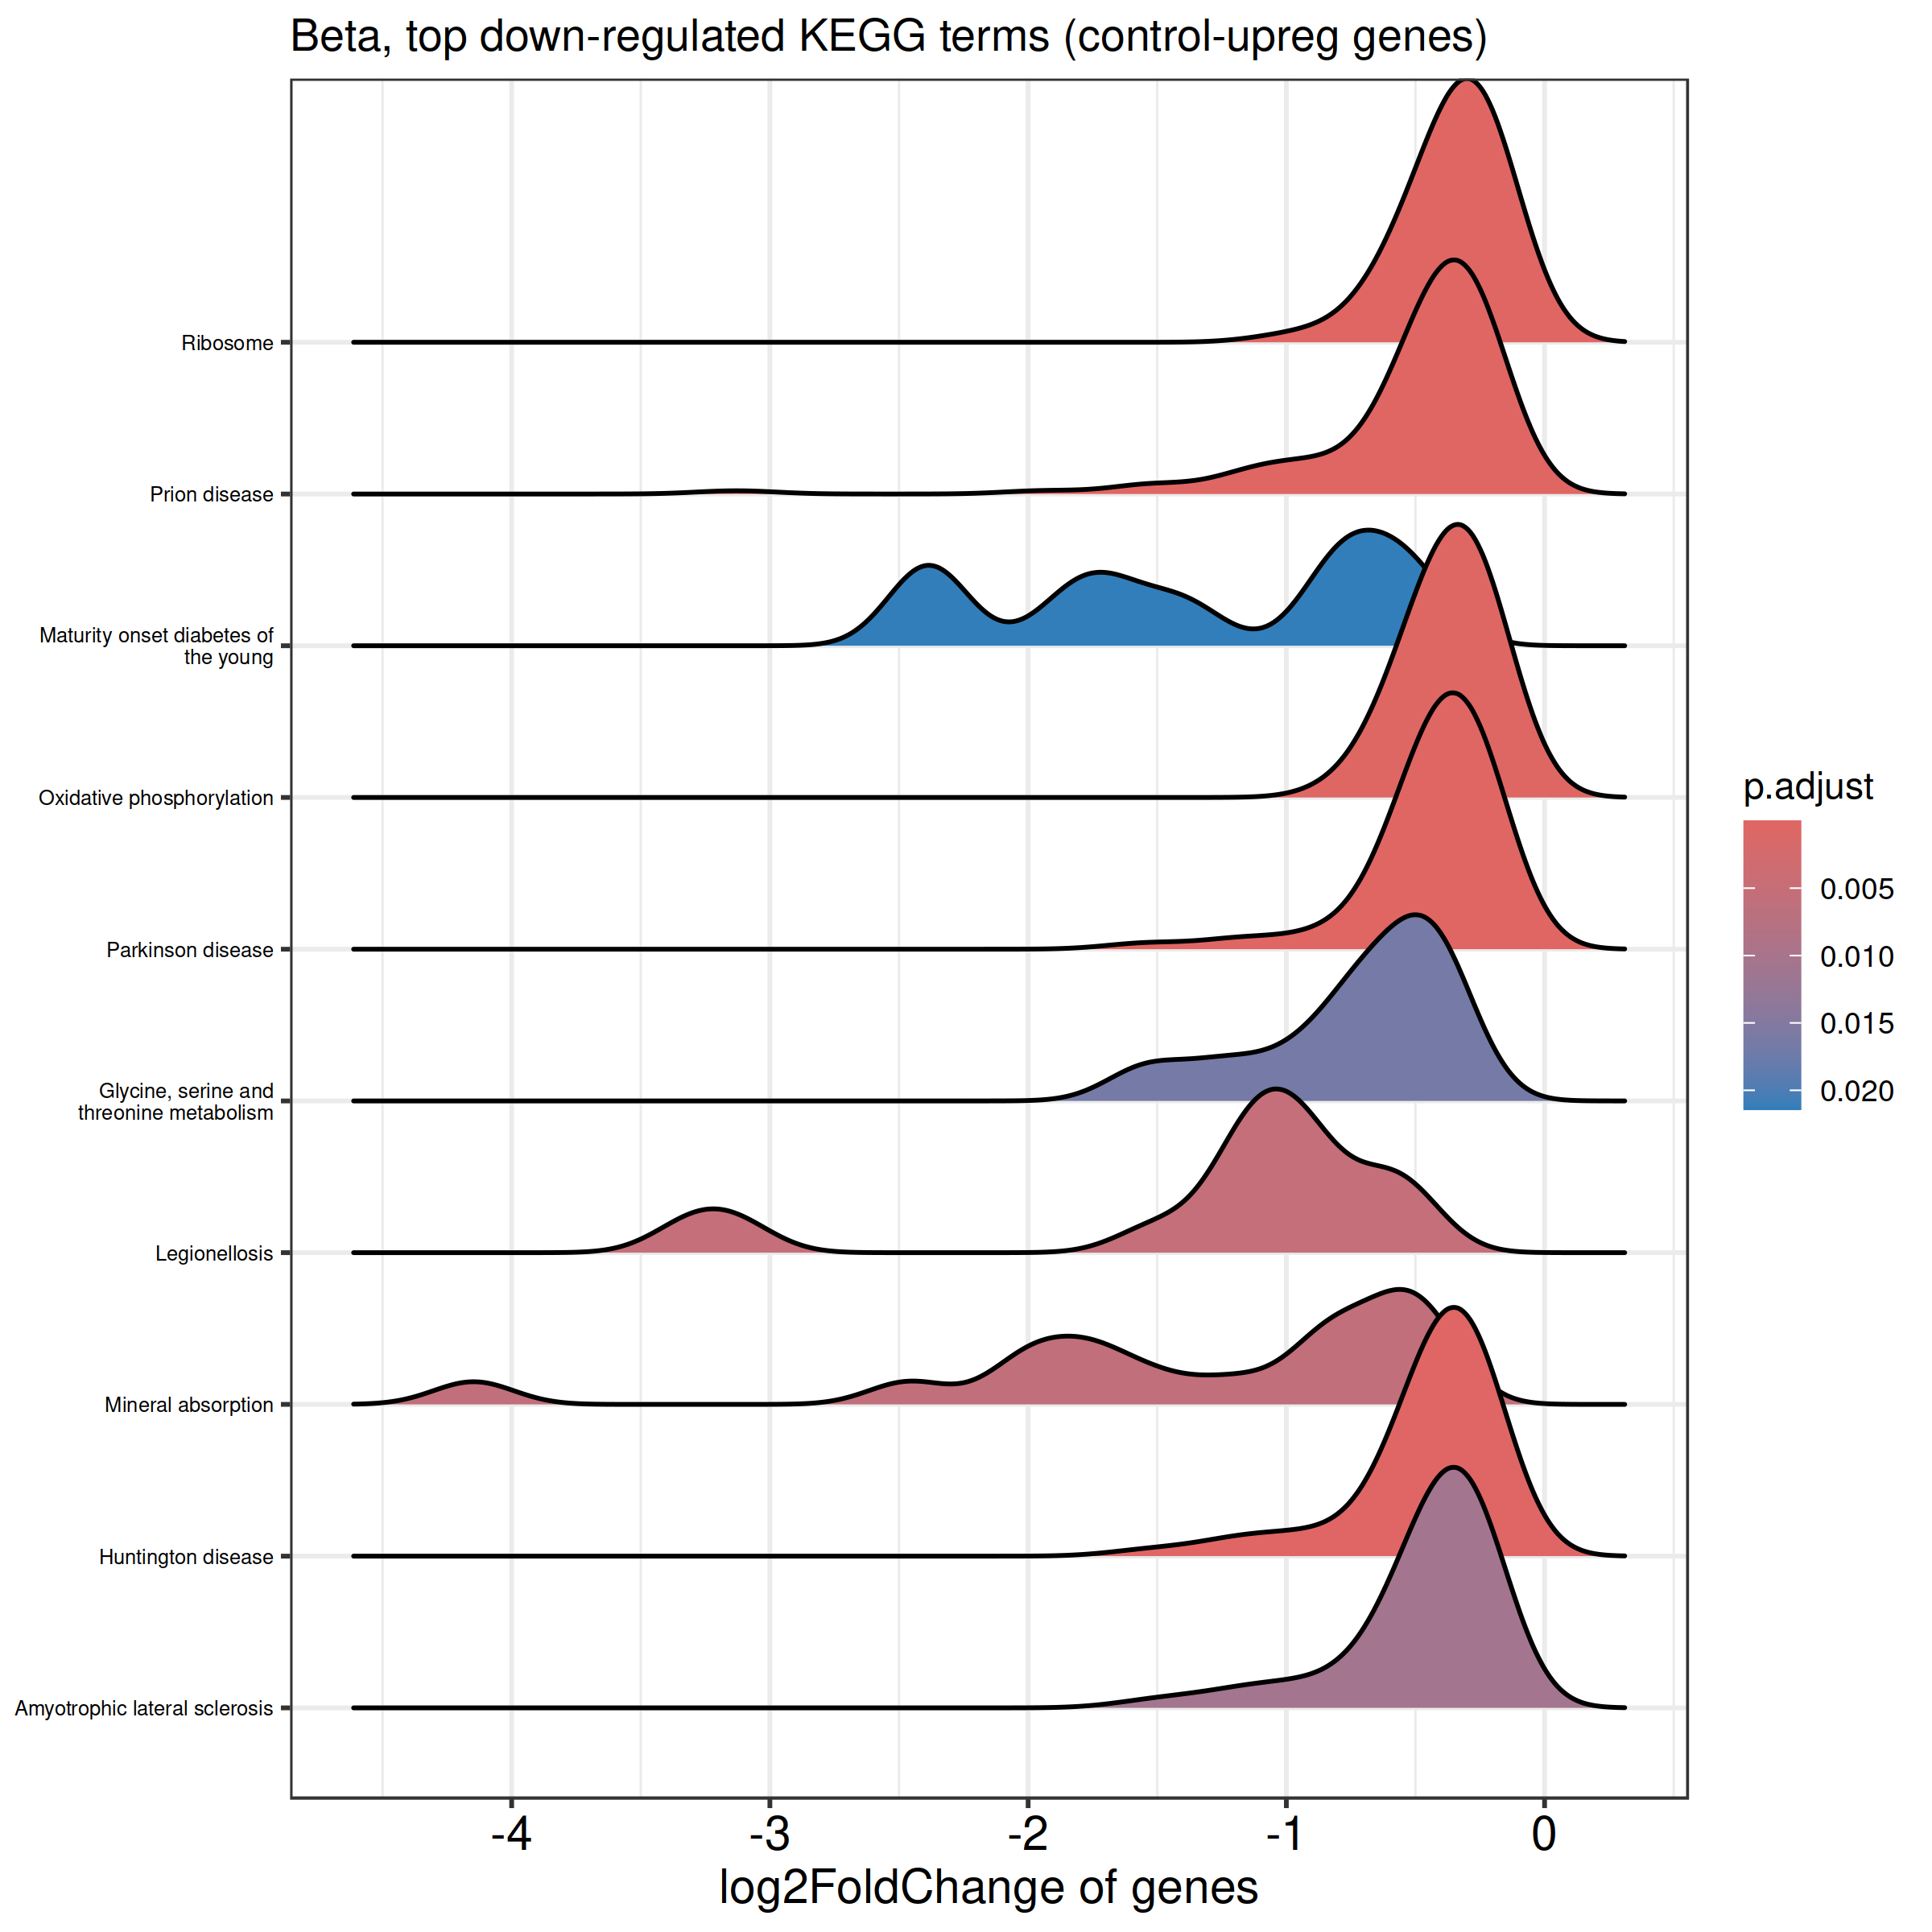

In [38]:
negNES <- kruv.df[kruv.df$NES < 0,]
if ( nrow(negNES) > 0 ) {
    negNES <- negNES[order(negNES$pvalue, decreasing = F),]
    kruv_to_plot <-  kruv
    kruv@result <- negNES

    p <- enrichplot::ridgeplot(kruv, showCategory = 10, decreasing = T) + 
        theme(axis.text.y = element_text(size = 6)) + xlab("log2FoldChange of genes") +
        ggtitle(paste0(cell.type, ", top down-regulated KEGG terms (control-upreg genes)"))
    print(p)
    } else {
        print("no significant terms with NES negative KEGG")
    }

## Set up Snakemake file to run for all samples

We can put all the code above into two R scripts and run for all samples. The specific scripts are in `scripts/ruvseq.R` and `scripts/t1d_nd_ruvseq.R`

One can set up a Snakefile like one in `scripts/snakefile` in order to run for all cell types.